<p style="font-family: times;line-height: 1.4em; font-size:20pt"> Bank Marketing Data Set

### Problem statement:
In this case study, you need to use the direct marketing campaigns data of a Portuguese banking institution. The
marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in
order to assess if the product (bank term deposit) would be ('yes') or not ('no') subscribed by the client.
The goal is to predict if the client will subscribe to a term product (variable Y).

### Deliverable requirements:
1. Provide exploratory data analysis (EDA) for data insights and to support your modeling decisions
2. Provide rationales for your data preparation decisions (e.g., missing imputation, one-hot encoding, etc.)
3. Run the model using at least 2 machine learning algorithms (one of them must be logistic regression) 

    a. Compare your model performance
    
    b. Tell us which algorithm you’d choose for implementation and why
    
    c. Name top three variables that are the most predictive
    
    
4. Provide some use cases that demonstrate business value of your analysis for the bank
5. If you could ask the bank for any additional data to solve the problem, what data would you ask and why? 

Upload Packages

In [1]:

#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random

#API 
import requests

#Automating
import time
import datetime
import warnings
import sys


#sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline

# import model and matrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score,plot_roc_curve
from sklearn.metrics import classification_report

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


# Algorithms, ordered by intepretation (easy to hard).
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

#Preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import chi2
from scipy.stats import chi2
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
%matplotlib inline



/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/nazlirafei/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:367

In [2]:
df=pd.read_csv('Case_Study_Data.csv')
df.shape

(41188, 21)

In [3]:
df=df.drop_duplicates()
df.shape

(41179, 21)

Useful functions

In [4]:
import statistics
def summary(df, col):
    min_age = df[col].min()
    max_age = df[col].max()
    median_age = df[col].mean()
    standard_dev_age = df[col].std()
    mode_age = statistics.mode(df[col])


    print(f"Min {col}: ", min_age)
    print(f"Max {col}: ", max_age)
    print(f"Median age: ", round(median_age, 2))
    print(f"Mode of {col} is: ", mode_age)
    print(f"Standard diveation of {col} is: ", round(standard_dev_age, 2))

    print('  ')

    # Quartiles
    print('1st Quartile: ', df[col].quantile(q = 0.25))
    print('2nd Quartile: ', df[col].quantile(q = 0.50))
    print('3rd Quartile: ', df[col].quantile(q = 0.75))
    print('4th Quartile: ', df[col].quantile(q = 1.00))


    #Calculate the outliers:
      # Interquartile range, IQR = Q3 - Q1
      # lower 1.5*IQR whisker = Q1 - 1.5 * IQR 
      # Upper 1.5*IQR whisker = Q3 + 1.5 * IQR
    outlier=df[col].quantile(q = 0.75) + 1.5*(df[col].quantile(q = 0.75) -  df[col].quantile(q = 0.25))
    
    print(f'{col} above: ', df[col].quantile(q = 0.75) + 
                          1.5*(df[col].quantile(q = 0.75) -  df[col].quantile(q = 0.25)),
          'are outliers')

    print('  ')

    print('Numerber of outliers: ', df[df[col] > outlier][col].count())
    print('Number of clients: ', len(df))
    #Outliers in %
    print('Outliers are:', round(df[df[col] > outlier][col].count()*100/len(df),2), '%')

In [5]:
#palette = "YlGnBu" , ="mako"
def box_hist_plot(df,col,palette="mako"):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    sns.boxplot(Y,df[col],palette=palette, ax=ax1)

    sns.histplot(data=df, x=df[col], hue=Y,palette=palette, ax=ax2,edgecolor = "black")
    ax1.titlesize = 29


    plt.suptitle(f'{col} Distribution',size=26)
    ax1.set_title(f"{col}: Box Plot",fontsize=20)
    ax2.set_title(f"{col}: Histogram",fontsize=20)


    ax1.tick_params(labelsize=13)
    ax2.tick_params(labelsize=13)


    ax1.set_xlabel('Y', fontsize=15)
    ax1.set_ylabel(col, fontsize=15)

    ax2.set_xlabel(col, fontsize=15)
    ax2.set_ylabel('Count', fontsize=15)


    params = {'legend.fontsize': 12,
              'legend.handlelength': 2}
    plt.rcParams.update(params)
    plt.show()


In [6]:
def hist_with_percentage(df,col,palette='mako'):
    plt.figure(figsize=(12,6))
    total = len(Y)*1.
    ax=sns.countplot(x=col, data=df, hue=Y,palette=palette)
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5), fontsize=13,xytext = (0, +12),  textcoords = 'offset points')

    #put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
    ax.yaxis.set_ticks(np.linspace(0, total, 11))

    #adjust the ticklabel to the desired format, without changing the position of the ticks.
    ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total), fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=15)


    ax.set_xlabel(col, fontsize=15)
    ax.set_ylabel('Count', fontsize=15)
    ax.set_title(col, fontsize=20)
    ax.tick_params(labelsize=13)
    sns.despine()
    plt.legend( loc = 'upper right',fontsize=15)
    plt.show()

    # ax.legend(labels=["no","yes"])

In [7]:
def hist_with_count(df,col):
    fig, ax = plt.subplots(figsize=(12,5))
    splot=sns.countplot(x = col, hue=Y, data = df,palette="mako")

    ax.set_xlabel(f'{col}', fontsize=15)
    ax.set_ylabel('Count', fontsize=15)
    ax.set_title(f'{col} Distribution', fontsize=18)
    ax.tick_params(labelsize=13)
    sns.despine()
    plt.legend( loc = 'upper right',fontsize=12)
    plt.show()

    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=12,
                       xytext = (0, +12),  textcoords = 'offset points')
    plt.show()

In [8]:
def double_hist_with_count(df,col1,col2):
    # Visualizing how Maritial Status and Education is distributed in the dataset. 
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))

    # First plot for marital status
    splot=sns.countplot(x = col1, data = df,hue=Y, ax = ax1,palette="mako")
    ax1.set_title(f"{col1} Distribution", fontsize = 18)
    ax1.set_xlabel(col1, fontsize = 14)
    ax1.set_ylabel("Count", fontsize = 14)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, fontsize = 14)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=12,
                       xytext = (0, +12), 
                       textcoords = 'offset points')

    # Second plot for Education distribution
    splot=sns.countplot(x = col2, data = df,hue=Y, ax = ax2,palette="mako")
    ax2.set_title(f"{col2} Distribution", fontsize = 18)
    ax2.set_xlabel(col2, fontsize = 14)
    ax2.set_ylabel("Count", fontsize = 14)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, fontsize = 14)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=12,
                       xytext = (0, +12), 
                       textcoords = 'offset points')
    plt.show()

In [9]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [10]:
def binary_percentage(df,target,col,ylabel,xlabel,title):
    import matplotlib.ticker as mtick

    churn_rate = df[[target, col]]
    sectors = churn_rate .groupby (target)
    churn_rate = pd.DataFrame(sectors[col].count())
    churn_rate ["Subscribed Rate"] = (
    churn_rate [col]/ sum(churn_rate [col]) )*100

    ax =  churn_rate[["Subscribed Rate"]].plot.bar(title = title,
                                              legend =True, table = False,grid = False,  subplots = False, 
                                              figsize =(12, 7), color = '#ec838a', fontsize = 15, stacked=False, 
                                              ylim =(0,100))

    plt.ylabel(ylabel,horizontalalignment="center",
                fontstyle = "normal", fontsize = 16, fontfamily = "sans-serif")

    plt.xlabel(xlabel,horizontalalignment="center",fontstyle = "normal",
               fontsize = 16,  fontfamily = "sans-serif")

    plt.title(f'{title} \n',horizontalalignment="center", 
              fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")

    plt.legend(loc='upper right', fontsize = "medium")
    plt.xticks(rotation=0, horizontalalignment="center")
    plt.yticks(rotation=0, horizontalalignment="right")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    x_labels = np.array(churn_rate[[col]])

    def add_value_labels(ax, spacing=5):   
        for rect in ax.patches:     
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2       
            space = spacing
            va = 'bottom'        
            if y_value < 0:           
                space *= -1          
                va = 'top'
            label = "{:.1f}%".format(y_value)    

            ax.annotate(label,
                        (x_value, y_value),         
                         xytext=(0, space),
                         textcoords="offset points", fontsize = "14", 
                         ha='center',va=va)
    add_value_labels(ax)
    ax.autoscale(enable=False, axis='both', tight=False)

In [11]:
# this function creates will automaticall generate the decision for the chi square test
def chi_square_test(data, feature):
    df = pd.crosstab(data[feature],data['y'])
    stat, p, dof, expected = chi2_contingency(df)
    print('='*60)
    print('Chi-Square Test for {}'.format(feature))
    print('='*60)
    print('degrees of freedom = %d' % dof)
    print('-'*60)
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('Results:')
    print(' ')
    print('probability = %.3f, critical = %.3f, stat = %.3f' % (prob, critical, stat))
    print('-'*60)
    print('Decision based on Chi-Square Statistics:')
    print(' ')
    if abs(stat) >= critical:
        print('y is dependent on {} : (reject H0)'.format(feature))
    else:
        print('y is independent on {} : (fail to reject H0)'.format(feature))
    # interpret p-value
    alpha = 1.0 - prob
    print('-'*60)
    print('Decision based on p-value:')
    print(' ')
    print('alpha = %.2f, p = %.3f' % (alpha, p))
    if p <= alpha:
        print('y is dependent on {} : (reject H0)'.format(feature))
    else:
        print('y is independent on {} : (fail to reject H0)'.format(feature))
    print('_'*60)
    print(' '*60)
    print(''*60)
    print(' '*60)





In [12]:
from sklearn.metrics import f1_score,plot_roc_curve

def ROC_curve(model,name_of_model ):
    # output ROC curve and auc for our model
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_roc_curve(model, X_train, y_train, ax=ax, name="Training")
    plot_roc_curve(model, X_test, y_test, ax=ax, name="Testing")

    line = np.linspace(0, 1)
    plt.plot(line, line, "b--")

    plt.title(f"{name_of_model} ROC/AUC ")
    plt.show()

In [13]:
# helper function for confusion matrices
def confmat(y_true, y_pred, title):
    """Produce a confusion matrix
    Each argument should be a list of either 1 or 2 elements"""
    fig, ax = plt.subplots(ncols=len(title), figsize=(16, 6))
    ax = ax if isinstance(ax, np.ndarray) else [ax]

    for a, b, c, d in zip(y_true, y_pred, title, ax):
        sns.heatmap(confusion_matrix(a, b), center=True, annot=True, fmt=",", ax=d)
        d.set_title(c)
        d.set_xlabel("Predicted")
        d.set_ylabel("True")
    plt.show()

In [14]:
# helper function for results table
def results_table(model,model_name,results):  
    test_pred = model.predict(X_test)
    
    auc=roc_auc_score(y_test, test_pred)
    acc = accuracy_score(y_test, test_pred )
    prec = precision_score(y_test, test_pred )
    rec = recall_score(y_test, test_pred )
    f1 = f1_score(y_test, test_pred )


    results_new = pd.DataFrame([[model_name, acc,auc, prec, rec, f1]], 
                               columns = ['Model', 'Accuracy','AUC', 
                                          'Precision', 'Recall', 'F1 Score'])

    results_1 = results.append(results_new, ignore_index = True)
    results2 = results_1.sort_values(["AUC","Accuracy", "Recall"], ascending = False)
    return results2

In [15]:
# Helper Function to draw bar plot for feature importance
def gradientbars(bars):
    grad = np.atleast_2d(np.linspace(0,1,256))
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    for bar in bars:
        bar.set_zorder(1)
        bar.set_facecolor('none')
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        ax.imshow(grad, extent=[x+w, x, y, y+h], aspect='auto', zorder=1)
    ax.axis(lim)

#index=top_10_coef_sorted.index
#values = top_10_coef_sorted['coef']
#mode_name='Logistic Regression'
def coeff_barplot(coefficients,mode_name): 
    top_10_coef_sorted=pd.DataFrame(coefficients, 
                                    X.columns, 
                                    columns=['coef'])\
                                    .sort_values(by='coef', ascending=False)[:10]
    
    print(top_10_coef_sorted)
    
    import matplotlib as mpl         
    # Variables
    index = top_10_coef_sorted.index
    values = top_10_coef_sorted['coef']
    plot_title = f'Coefficients in {mode_name}'
    title_size = 18
    x_label = 'Coefficients'
    filename = 'barh-plot'

    fig, ax = plt.subplots(figsize=(10,6), facecolor=(.94, .94, .94))
    mpl.pyplot.viridis()

    bar = ax.barh(index, values)
    plt.tight_layout()


    title = plt.title(plot_title, pad=20, fontsize=title_size)
    title.set_position([.45, 1])

    gradientbars(bar)


    rects = ax.patches
    # Place a label for each bar
    for rect in rects:
        # Get X and Y placement of label from rect
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        # Number of points between bar and label; change to your liking
        space = -40
        # Vertical alignment for positive values
        ha = 'left'

        # If value of bar is negative: place label to the left of the bar
        if x_value < 0:
            # Invert space to place label to the left
            space *= -1
            # Horizontally align label to the right
            ha = 'center'

        # Use X value as label and format number
        label = '{:,.02f}'.format(x_value)

        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at bar end
            xytext=(space, 0),          # Horizontally shift label by `space`
            textcoords='offset points', # Interpret `xytext` as offset in points
            fontsize=14,
            va='center',                # Vertically center label
            ha=ha,                      # Horizontally align label differently for positive and negative values
            color = 'white')            # Change label color to white


    #Set x-label
    ax.set_xlabel(x_label, color='#525252')

    plt.ylabel("Features", fontsize=16)
    plt.xlabel('Coefficients', fontsize=16)
    plt.xticks([])
    sns.despine(left=True, bottom=True)
    plt.grid(b=None)
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.show()
    
    

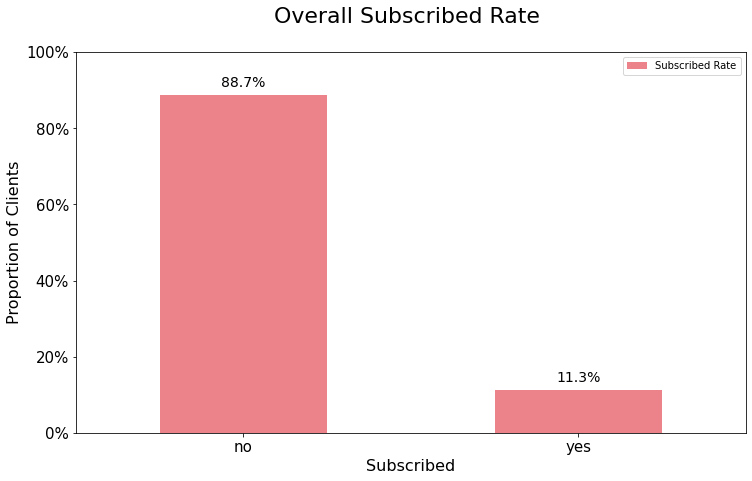

In [16]:
import matplotlib.ticker as mtick

churn_rate = df[["y", "pdays"]]
sectors = churn_rate .groupby ("y")
churn_rate = pd.DataFrame(sectors["pdays"].count())
churn_rate ["Subscribed Rate"] = (
churn_rate ["pdays"]/ sum(churn_rate ["pdays"]) )*100

ax =  churn_rate[["Subscribed Rate"]].plot.bar(title = 'Overall Subscribed Rate',
                                          legend =True, table = False,grid = False,  subplots = False, 
                                          figsize =(12, 7), color = '#ec838a', fontsize = 15, stacked=False, 
                                          ylim =(0,100))

plt.ylabel('Proportion of Clients',horizontalalignment="center",
            fontstyle = "normal", fontsize = 16, fontfamily = "sans-serif")

plt.xlabel('Subscribed',horizontalalignment="center",fontstyle = "normal",
           fontsize = 16,  fontfamily = "sans-serif")

plt.title('Overall Subscribed Rate \n',horizontalalignment="center", 
          fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")

plt.legend(loc='upper right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
x_labels = np.array(churn_rate[["pdays"]])

def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:     
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing
        va = 'bottom'        
        if y_value < 0:           
            space *= -1          
            va = 'top'
        label = "{:.1f}%".format(y_value)    
 
        ax.annotate(label,
                    (x_value, y_value),         
                     xytext=(0, space),
                     textcoords="offset points", fontsize = "14", 
                     ha='center',va=va)
add_value_labels(ax)
ax.autoscale(enable=False, axis='both', tight=False)

> ### exploratory data analysis (EDA) for data insights 

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> The dataset contains 41,188 rows and 21 columns in .csv format, where are 10 categorical featuresand 10 numeric features.
In our target value ’yes’ means that client subscribed a term deposit, ’no’ when didn’t do it. </p>

In [17]:
df=pd.read_csv('Case_Study_Data.csv')
df.shape

(41188, 21)

In [18]:
df=df.drop_duplicates()
df.shape

(41179, 21)

In [19]:
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41179 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             37435 non-null  float64
 1   job             41179 non-null  object 
 2   marital         41179 non-null  object 
 3   education       41179 non-null  object 
 4   default         41179 non-null  object 
 5   housing         41179 non-null  object 
 6   loan            41179 non-null  object 
 7   contact         41179 non-null  object 
 8   month           41179 non-null  object 
 9   day_of_week     41179 non-null  object 
 10  duration        41179 non-null  int64  
 11  campaign        41179 non-null  int64  
 12  pdays           41179 non-null  int64  
 13  previous        41179 non-null  int64  
 14  poutcome        41179 non-null  object 
 15  emp.var.rate    41179 non-null  float64
 16  cons.price.idx  36031 non-null  float64
 17  cons.conf.idx   41179 non-null 

In [21]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,37435.000000,41179.000000,41179.000000,41179.000000,41179.000000,41179.000000,36031.000000,41179.000000,41179.000000,41179.000000
mean,39.999279,258.309260,2.567887,962.467471,0.173001,0.081862,93.575615,-40.503215,3.621217,5167.033053
std,10.414284,259.299398,2.770238,186.930552,0.494949,1.570894,0.579210,4.627903,1.734458,72.250910
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [22]:
df.isnull().sum()

age               3744
job                  0
marital              0
education            0
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx    5148
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

<p style="font-family: times;line-height: 1.4em; font-size:18pt"> Output variable (desired target):

<p style="font-family: times;line-height: 1.4em; font-size:12pt">  y - has the client subscribed a term deposit? (binary: 'yes','no')

In [23]:
df['y'].value_counts()

no     36540
yes     4639
Name: y, dtype: int64

In [24]:
#  read Y seperately
Y=df['y'] 

<p style="font-family: times;line-height: 1.4em; font-size:18pt"> List of Numeric and Categorical columns 

In [25]:
numerical_cols = list(df.select_dtypes(exclude=['object']))

categorical_cols = list(df.select_dtypes(include=['object']))

In [26]:
print(f'we have {len(numerical_cols)} numerical columns:{numerical_cols}')
print('---'*35)
print(f'we have {len(categorical_cols)} categorical columns:  {categorical_cols}')

we have 10 numerical columns:['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
---------------------------------------------------------------------------------------------------------
we have 11 categorical columns:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


<p style="font-family: times;line-height: 1.4em; font-size:18pt"> Features

<p style="font-family: times;line-height: 1.4em; font-size:18pt"> Data that is specific to each client:

<p style="font-family: times;line-height: 1.4em; font-size:16pt"> 1- Age (Numerical) </p>

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> Range of Age is in range between 17 and 98 yearsold. Bar plot and Histogram are shown below. As we see this plot is right-skewed, but very close to normal distribution. Distribution for clients, who subscribed a term deposit is more diffused, but we have to consider that their population is fewer.</p>

'#A2D9CE'

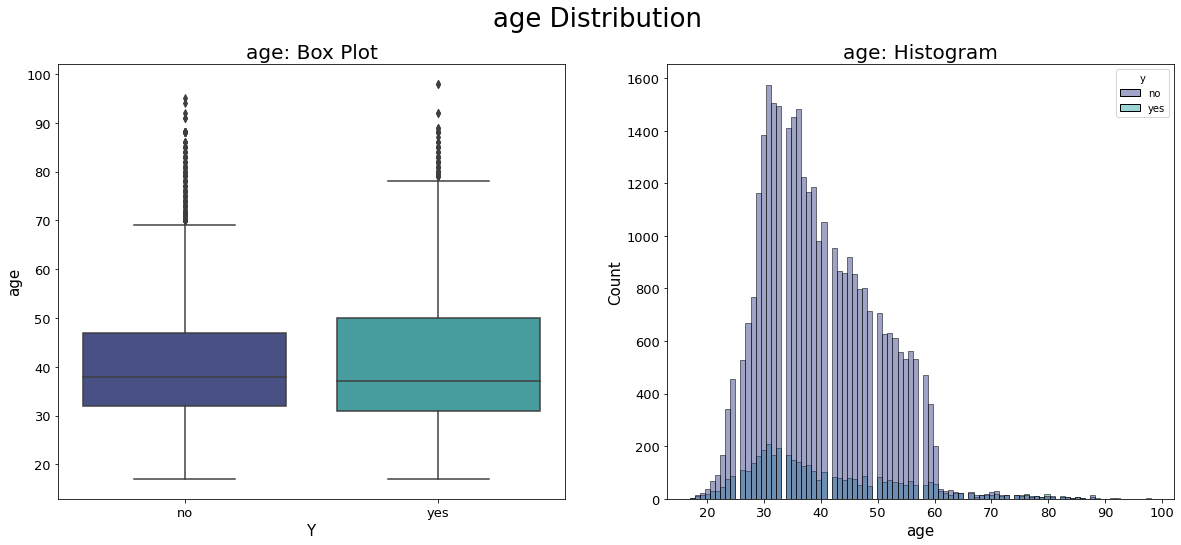

In [27]:
box_hist_plot(df,'age')

In [28]:
summary(df,'age')

Min age:  17.0
Max age:  98.0
Median age:  40.0
Mode of age is:  31.0
Standard diveation of age is:  10.41
  
1st Quartile:  32.0
2nd Quartile:  38.0
3rd Quartile:  47.0
4th Quartile:  98.0
age above:  69.5 are outliers
  
Numerber of outliers:  423
Number of clients:  41179
Outliers are: 1.03 %


<p style="font-family: times;line-height: 1.4em; font-size:16pt"> 2 - Job (categorical)</p>

<p style="font-family: times;line-height: 1.4em; font-size:12pt">job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','selfemployed','services','student','technician','unemployed','unknown')

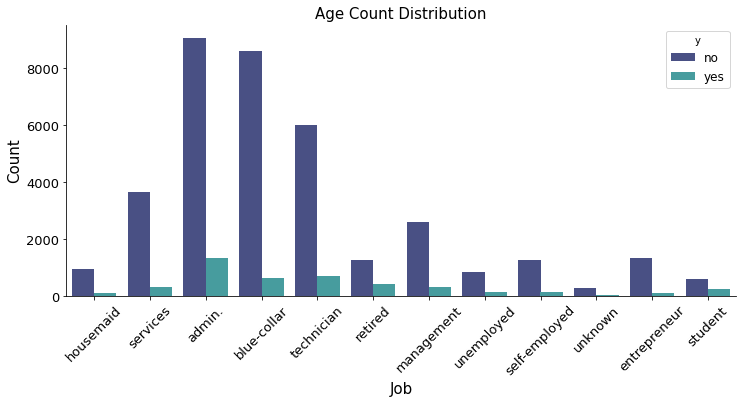

In [29]:
fig, ax = plt.subplots(figsize=(12,5))
sns.countplot(x = 'job', data = df, hue=Y,palette="mako")
plt.xticks(rotation=45)
ax.set_xlabel('Job', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Age Count Distribution', fontsize=15)
ax.tick_params(labelsize=13)
sns.despine()

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> As we see <span style="color:blue">.admin</span> and then <span style="color:blue">technician and blue-collar</span>   are top two job type that subscribed to a term deposit ( we have to address for unknown here), BUT This is simply because we have more customers working as admin than any other profession. </p>



<p style="font-family: times;line-height: 1.4em; font-size:16pt"> 3 & 4 - Marital Status & Education 

<p style="font-family: times;line-height: 1.4em; font-size:12pt"> 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br/>
    4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

</p>

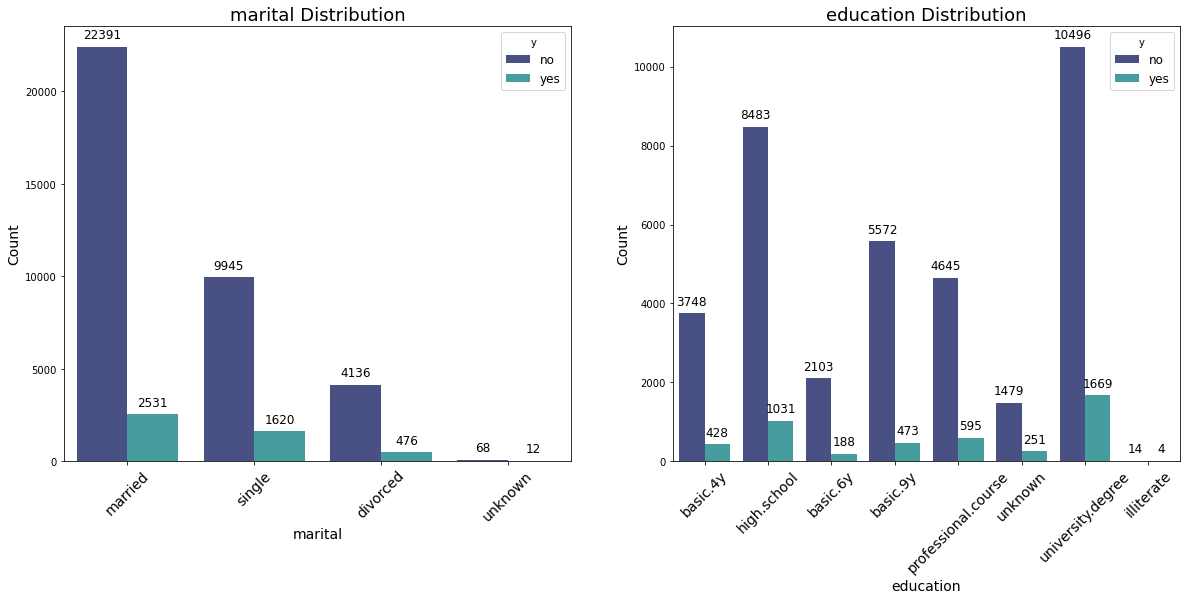

In [30]:
double_hist_with_count(df,"marital","education")

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> 
    Marital: As we see in plot for marital status, married group is the biggest group in our data and t has the most subscribed and also maximum unsunscribed to a term deposite (55% subscribedand and 61% unsubscribed). Single (35% subscribedand and 27% unsubscribed) and divorced (10% subscribedand and 11% unsubscribed) are the second and third largest group for both subscibed and unsubscribed to a term. </p> <br/>
    <p style="font-family: times;line-height: 1.4em; font-size:14pt"> 
    Education: groups of unicersity degree and highschool education ere approached more as compare to other also they subscribed more.


In [31]:
pd.crosstab(df['y'],df['marital']).apply(lambda r: round((r/r.sum()),2), axis=1)

marital,divorced,married,single,unknown
y,,,,
no,0.11,0.61,0.27,0.0
yes,0.10,0.55,0.35,0.0


In [32]:
pd.crosstab(df['y'],df['education']).apply(lambda r:  round((r/r.sum()),2), axis=1)

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
y,,,,,,,,
no,0.10,0.06,0.15,0.23,0.0,0.13,0.29,0.04
yes,0.09,0.04,0.10,0.22,0.0,0.13,0.36,0.05


<p style="font-family: times;line-height: 1.4em; font-size:14pt">
    From above table we see that 'university degree' education has the highest percentage of subscribed and unsubscribed to the bank term deposit (36% subscribedand and 29% unsubscribed). And then 'high school' has the second place with 22% for subscribedand and 23% for unsubscribed.
</p>

<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    5 - Default <br/>
    <p style="font-family: times;line-height: 1.4em; font-size:12pt">
    5 - default: has credit in default? (categorical: 'no','yes','unknown')
</p>

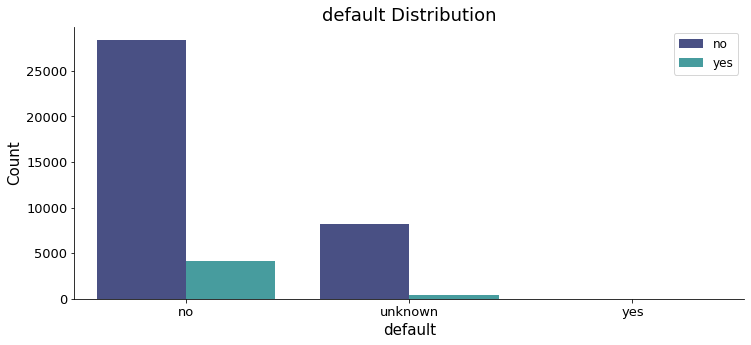

In [33]:
hist_with_count(df,'default')

<p style="font-family: times;line-height: 1.4em; font-size:14pt">
    

<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    6 & 7 - housing & loan 
    <br/>
    <p style="font-family: times;line-height: 1.4em; font-size:12pt">
         housing: has housing loan? (categorical: 'no','yes','unknown') <br/>
         loan: has personal loan? (categorical: 'no','yes','unknown'))
</p>

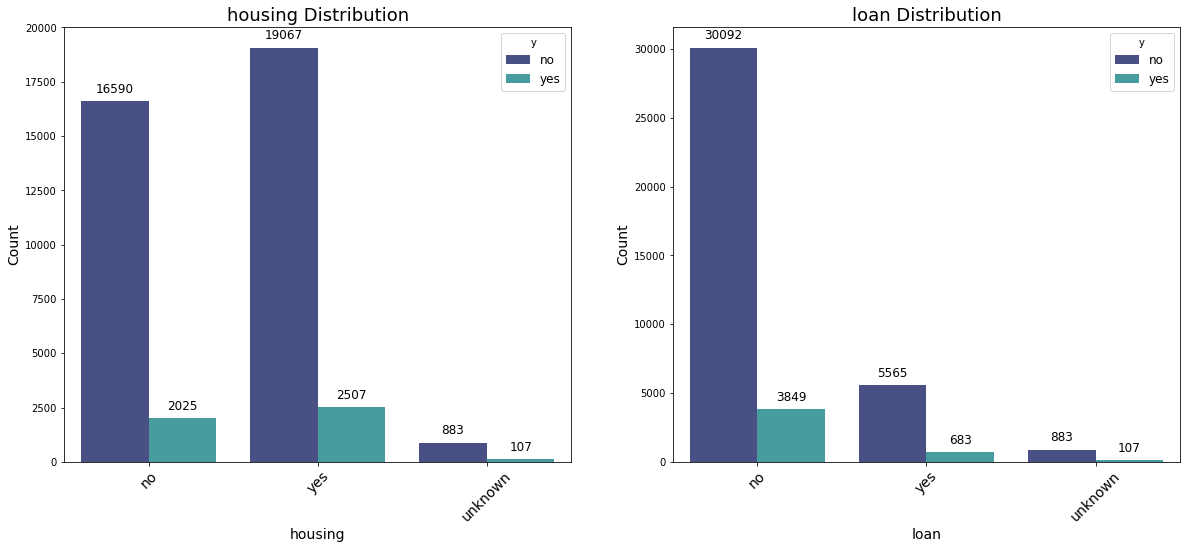

In [34]:
double_hist_with_count(df,"housing","loan");

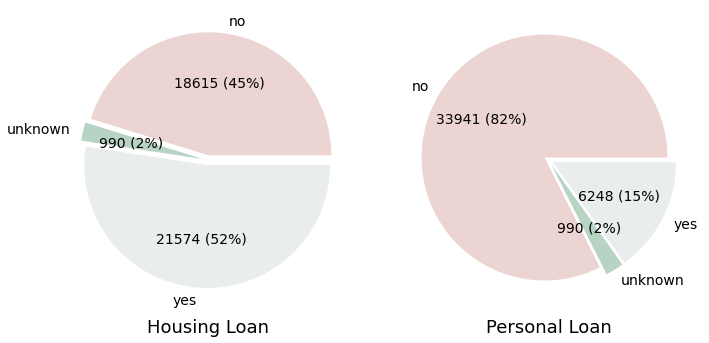

In [35]:
def label_function(val):
    return f'{val / 100 * len(df):.0f} ({val:.0f}%)'

distance = 0.04

N = 50

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

df.groupby('housing').size().plot(kind='pie',explode=(distance, distance, distance), autopct=label_function, textprops={'fontsize': 14},
                                  colors=['#EBD4D1', '#B7D3C4', '#EAEDED'], ax=ax1)
df.groupby('loan').size().plot(kind='pie',explode=(distance, distance, distance),  autopct=label_function, textprops={'fontsize': 14},
                                 colors=['#EBD4D1', '#B7D3C4', '#EAEDED'], ax=ax2)
ax1.set_ylabel(' ', size=20)
ax2.set_ylabel(' ', size=20)
ax1.set_xlabel('Housing Loan', size=18)
ax2.set_xlabel('Personal Loan', size=18)
plt.tight_layout()
plt.show()

<p style="font-family: times;line-height: 1.4em; font-size:14pt">
    Housing loan: From above plots, it does not seem housing have much effect on number of term deposi purchasd.
    <p style="font-family: times;line-height: 1.4em; font-size:14pt">
    Personal loan: Also, we can see clients without personal loan were approached more than those with personal loans, and they take ore deposit rate as well.

<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    8 - Contact 
<p style="font-family: times;line-height: 1.4em; font-size:12pt">
    contact: contact communication type (categorical: 'cellular','telephone')
</p>

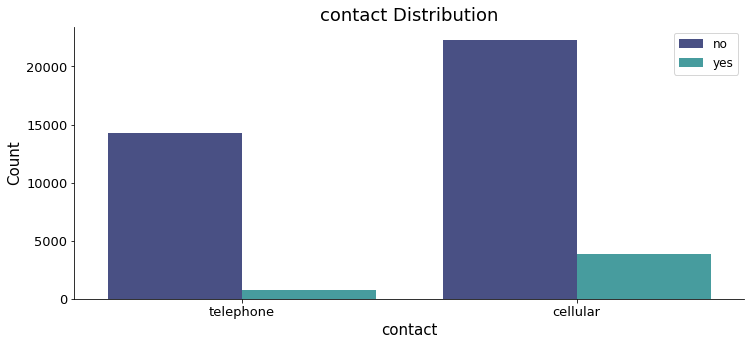

In [36]:
hist_with_count(df,'contact')

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> 
As we see, those with cellular number were approached more and they take deposit term more.

<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    9 & 10 - Month and Day of the weak
<p style="font-family: times;line-height: 1.4em; font-size:12pt">

month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br/>
day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')</p>

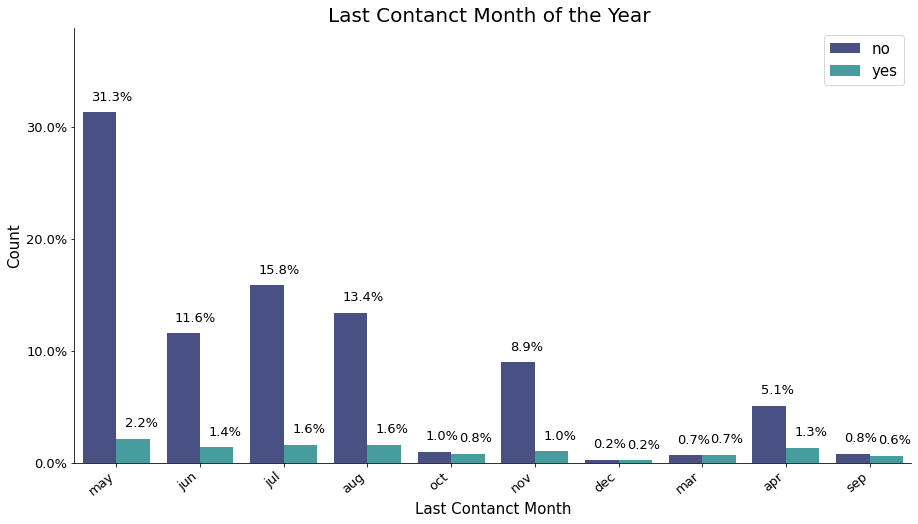

In [37]:
plt.figure(figsize=(15,8))
total = len(Y)*1.
ax=sns.countplot(x='month', data=df, hue=Y,palette="mako")
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5), fontsize=13,xytext = (0, +12),  textcoords = 'offset points')

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks.
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total), fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=15)


ax.set_xlabel('Last Contanct Month', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Last Contanct Month of the Year ', fontsize=20)
ax.tick_params(labelsize=13)
sns.despine()
plt.legend( loc = 'upper right',fontsize=15)


ax.set_ylim(0.0, 16000.0)

 
# ax.legend(labels=["no","yes"])
plt.show()

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> As we see May is the month of highest level of marketing activity, however ratio of responded are less compared to  March, September, October and December , which ratio od positive respond is very high, so campaign should invest more on these months.

(0.0, 11000.0)

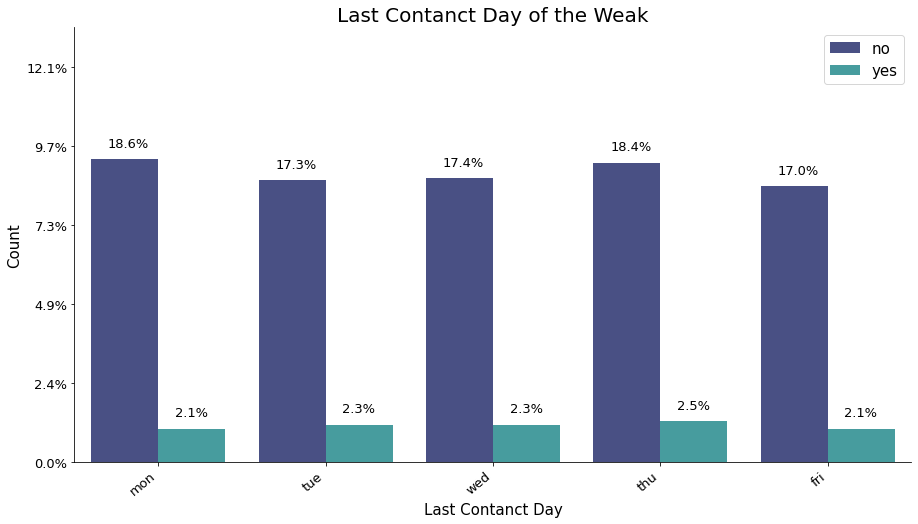

In [38]:
plt.figure(figsize=(15,8))

ax=sns.countplot(x='day_of_week', data=df, hue=Y,palette="mako")
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5), fontsize=13,xytext = (0, +12),  textcoords = 'offset points')



#adjust the ticklabel to the desired format, without changing the position of the ticks.
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total), fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=15)


ax.set_xlabel('Last Contanct Day', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Last Contanct Day of the Weak', fontsize=20)
ax.tick_params(labelsize=13)
sns.despine()
plt.legend( loc = 'upper right',fontsize=15)


ax.set_ylim(0.0, 11000.0)

 
# ax.legend(labels=["no","yes"])

In [39]:
df['day_of_week'].unique()

array(['mon', 'tue', 'wed', 'thu', 'fri'], dtype=object)

<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    11 - Duration 
<p style="font-family: times;line-height: 1.5em; font-size:12pt">
    duration: last contact duration, in seconds (numeric). <br/>
    Important note: this attribute highly affects the output
target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end
of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be
discarded if the intention is to have a realistic predictive model.
</p>

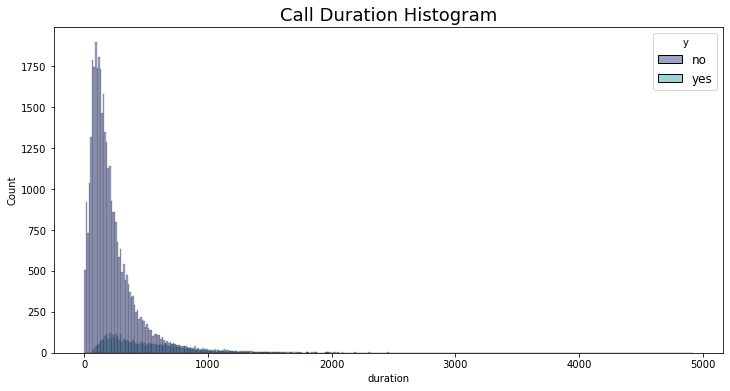

In [40]:
fig, ax = plt.subplots(figsize=(12,6))


sns.histplot(data=df, x=df['duration'], hue=Y,palette="mako")
ax.titlesize = 29


ax.set_title("Call Duration Histogram",fontsize=18)

plt.show()

In [41]:
summary(df,'duration')

Min duration:  0
Max duration:  4918
Median age:  258.31
Mode of duration is:  85
Standard diveation of duration is:  259.3
  
1st Quartile:  102.0
2nd Quartile:  180.0
3rd Quartile:  319.0
4th Quartile:  4918.0
duration above:  644.5 are outliers
  
Numerber of outliers:  2963
Number of clients:  41179
Outliers are: 7.2 %


<p style="font-family: times;line-height: 1.4em; font-size:18pt"> Data that is not client specific:<br/>

<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    12 - Campaign <p/>
<p style="font-family: times;line-height: 1.4em; font-size:12pt">
campaign: number of contacts performed during this campaign and for this client (numeric, includes last
contact)

</p>

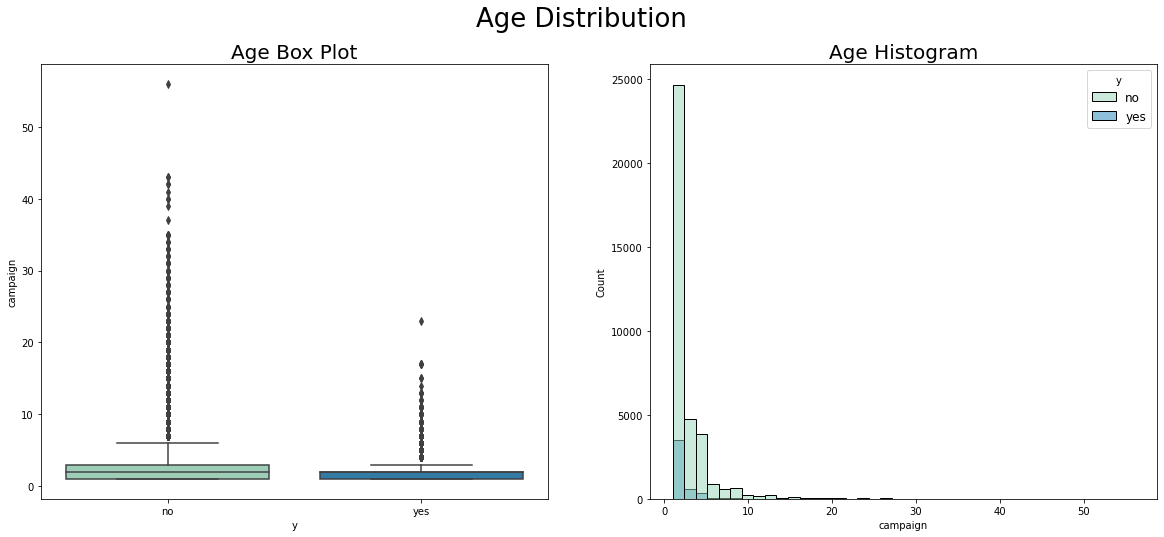

In [42]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.boxplot(Y,df['campaign'],palette="YlGnBu", ax=ax1)

sns.histplot(data=df, x=df['campaign'], hue=Y,palette="YlGnBu",bins=40, ax=ax2)
ax1.titlesize = 29


plt.suptitle('Age Distribution',size=26)
ax1.set_title("Age Box Plot",fontsize=20)
ax2.set_title("Age Histogram",fontsize=20)
plt.show()
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)


In [43]:
summary(df,'campaign')

Min campaign:  1
Max campaign:  56
Median age:  2.57
Mode of campaign is:  1
Standard diveation of campaign is:  2.77
  
1st Quartile:  1.0
2nd Quartile:  2.0
3rd Quartile:  3.0
4th Quartile:  56.0
campaign above:  6.0 are outliers
  
Numerber of outliers:  2406
Number of clients:  41179
Outliers are: 5.84 %


<p style="font-family: times;line-height: 1.4em; font-size:14pt">
    We can see in the plot that our histogram is skewed to the right, and also we see when number of calls increase there is no increase in successful respond of customers, based on what we see and 3rd quartile, we might want to put a policy that no more than 3 calls should be made, since it is not helping the goal of campaign, and it is just extra cost of time and money.
</p>

In [44]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no
3,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56.0,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no


<p style="font-family: times;line-height: 1.4em; font-size:16pt">
        13 - P-Days <p/>
<p style="font-family: times;line-height: 1.4em; font-size:12pt">
pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric;
999 means client was not previously contacted)

</p>

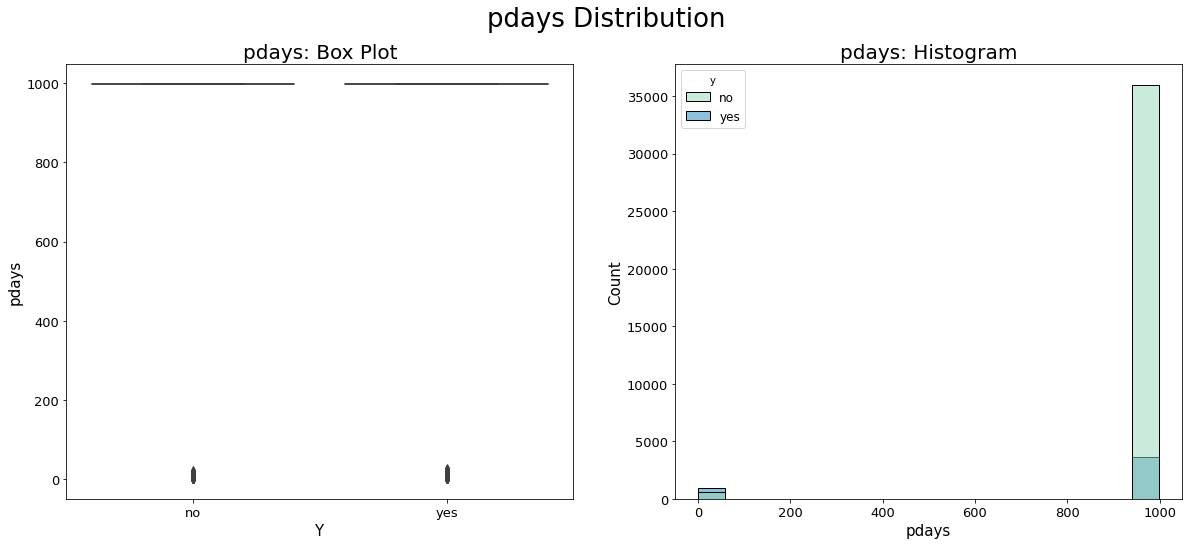

In [45]:
%matplotlib inline
box_hist_plot(df,'pdays',"YlGnBu")


In [46]:
summary(df,'pdays')

Min pdays:  0
Max pdays:  999
Median age:  962.47
Mode of pdays is:  999
Standard diveation of pdays is:  186.93
  
1st Quartile:  999.0
2nd Quartile:  999.0
3rd Quartile:  999.0
4th Quartile:  999.0
pdays above:  999.0 are outliers
  
Numerber of outliers:  0
Number of clients:  41179
Outliers are: 0.0 %


In [47]:
print('Numerber of Zeroes: ', df[df['pdays'] < 1 ]['pdays'].count())
print('Numerber of 999s: ', df[df['pdays'] == 999 ]['pdays'].count())
print('Number of clients: ', len(df))
#Outliers in %
print('Percentage of Zeroes & 999s out of all data is:', round((df[df['pdays'] < 1]['pdays'].count() + df[df['pdays'] == 999 ]['pdays'].count() ) *100/len(df),2), '%')

Numerber of Zeroes:  15
Numerber of 999s:  39664
Number of clients:  41179
Percentage of Zeroes & 999s out of all data is: 96.36 %


In [48]:
condition = (df['pdays'] < 999) & (df['pdays'] >  0)
df_temp=df.loc[condition]

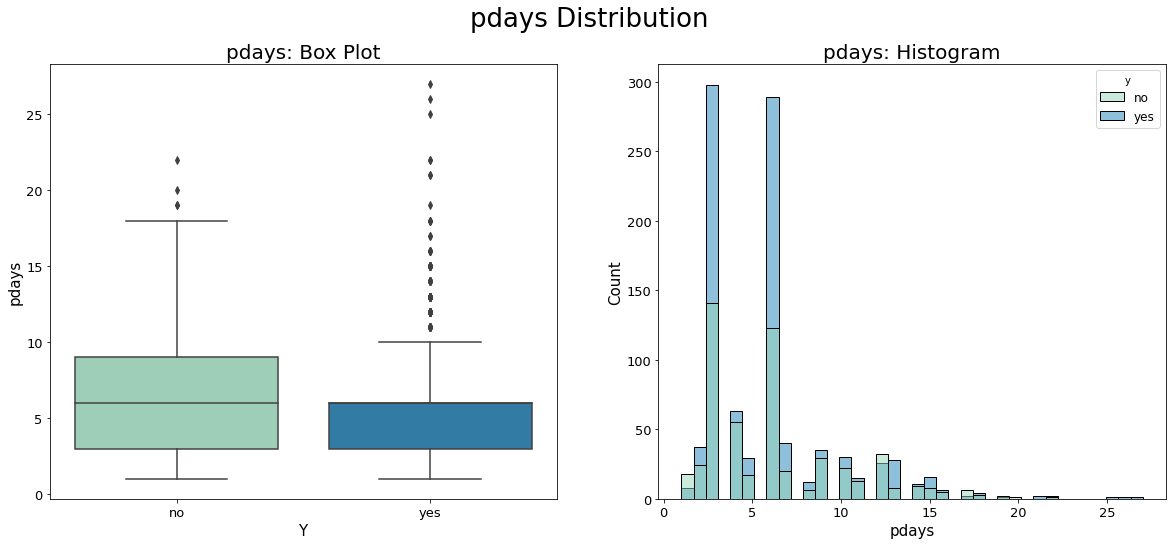

In [49]:
box_hist_plot(df_temp,'pdays',"YlGnBu")

In [50]:
summary(df_temp,'pdays')

Min pdays:  1
Max pdays:  27
Median age:  6.07
Mode of pdays is:  3
Standard diveation of pdays is:  3.8
  
1st Quartile:  3.0
2nd Quartile:  6.0
3rd Quartile:  7.0
4th Quartile:  27.0
pdays above:  13.0 are outliers
  
Numerber of outliers:  82
Number of clients:  1500
Outliers are: 5.47 %


<p style="font-family: times;line-height: 1.4em; font-size:14pt"> Results from pdays plot shows that when number of days that has passed from last contact is fewer (lesser) , chance of a customer to subscribe is higher. 

<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    14 - Previous <p/>
<p style="font-family: times;line-height: 1.4em; font-size:12pt">
    previous: number of contacts performed before this campaign and for this client (numeric)

</p>

In [51]:
min_previous = df['previous'].min()
max_previous = df['previous'].max()
range_ =max_previous-min_previous
print("Min previous: ", min_previous)
print("Max previous: ", max_previous)
print("Range of previous is: ", range_)

Min previous:  0
Max previous:  7
Range of previous is:  7


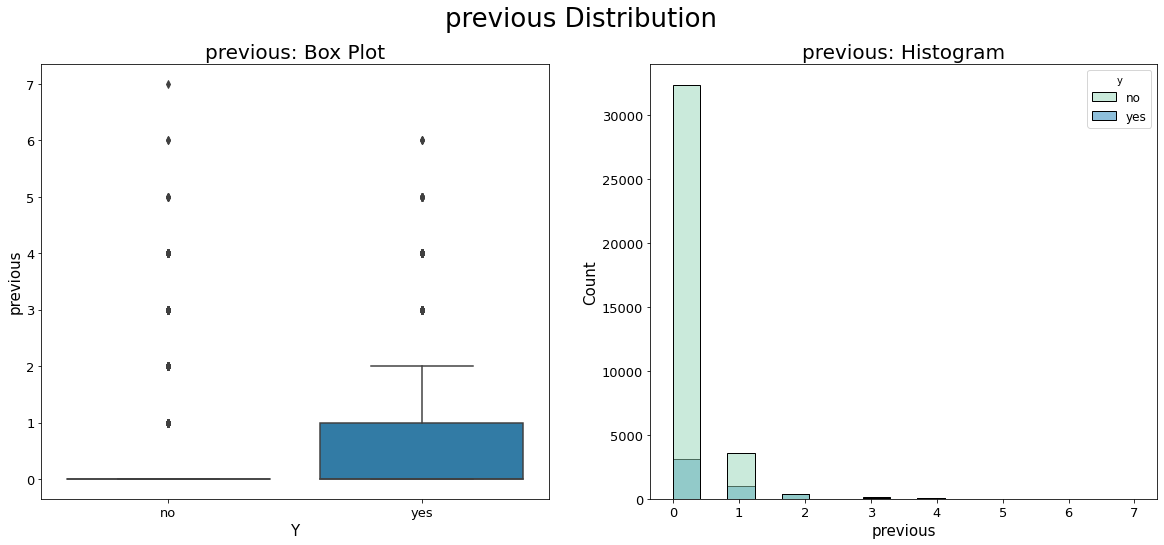

In [52]:
box_hist_plot(df,'previous',"YlGnBu")

In [53]:
print('Numerber of Zeroes: ', df[df['previous'] == 0 ]['previous'].count())
print('Number of clients: ', len(df))
#Outliers in %
print('Zeroes Percentage out of all data:', round((df[df['previous'] < 1]['previous'].count() ) *100/len(df),2), '%')


Numerber of Zeroes:  35554
Number of clients:  41179
Zeroes Percentage out of all data: 86.34 %


<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    15 - P Outcome <p/>
<p style="font-family: times;line-height: 1.4em; font-size:12pt">
    poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

</p>

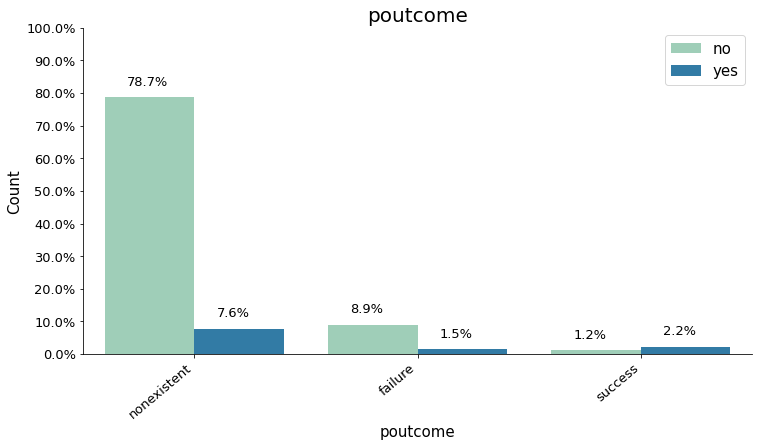

In [54]:
hist_with_percentage(df,'poutcome',palette="YlGnBu")

<p style="font-family: times;line-height: 1.4em; font-size:14pt">
    As we see in previous campaign success was due to higher subscribe rate compare to falure of the previous capaign which we can see was because of less people subscribed compared to thode who were not subscribed. And for unknown results, we see those who did not subscribed to a deposit were higher than those who did.
</p>

<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    16 - employment variation rate <p/>
<p style="font-family: times;line-height: 1.4em; font-size:12pt">
    emp.var.rate: employment variation rate - quarterly indicator (numeric)

</p>

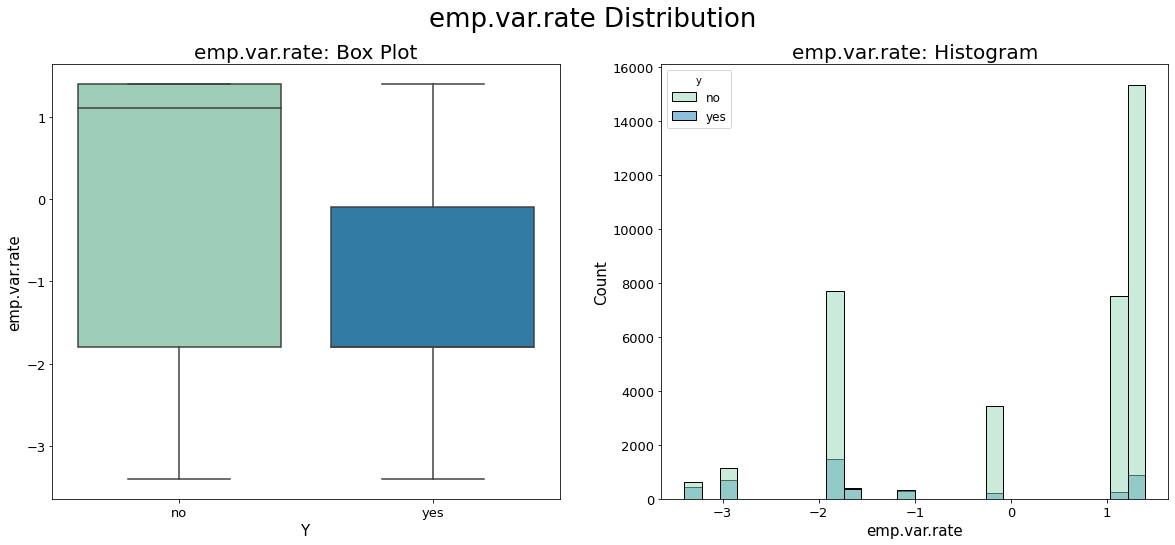

In [55]:
box_hist_plot(df,'emp.var.rate',"YlGnBu")

<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    17 - consumer price index <p/>
<p style="font-family: times;line-height: 1.4em; font-size:12pt">
    cons.price.idx: consumer price index - monthly indicator (numeric)

</p>

<p style="font-family: times;line-height: 1.4em; font-size:14pt">"
    The Consumer Price Index (CPI) is a measure of the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services." <p/> 

[refrence link](https://www.bls.gov/cpi/#:~:text=The%20Consumer%20Price%20Index%20(CPI,U.S.%20and%20various%20geographic%20areas)

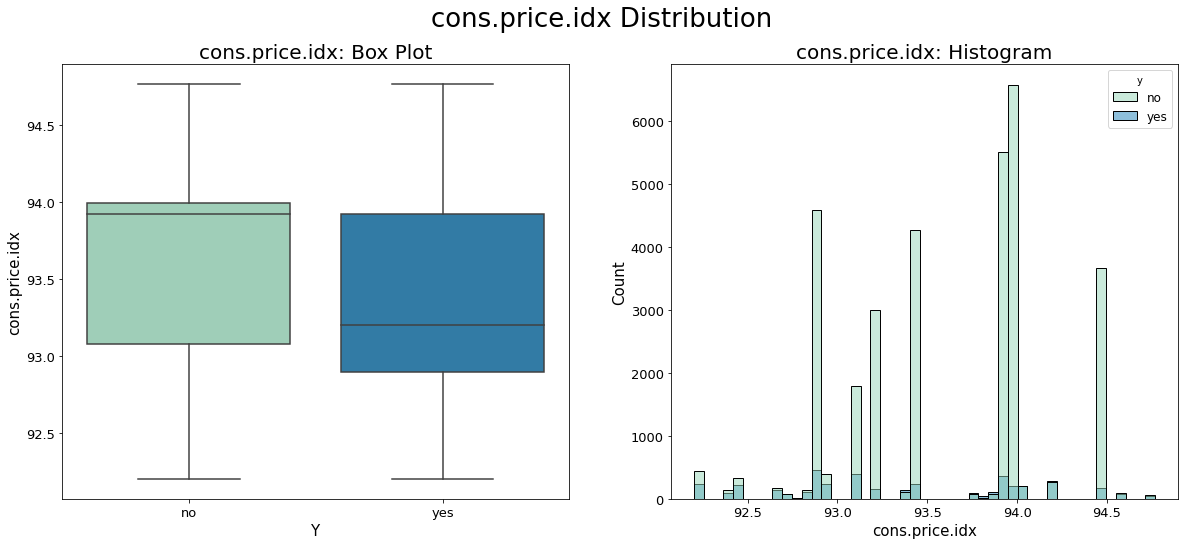

In [56]:
box_hist_plot(df,'cons.price.idx',"YlGnBu")

<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    18 - consumer confidence index <p/>
<p style="font-family: times;line-height: 1.4em; font-size:12pt">
    cons.conf.idx: consumer confidence index - monthly indicator (numeric)

</p>

<p style="font-family: times;line-height: 1.4em; font-size:14pt">"A consumer confidence index is an economic indicator published by various organizations in several countries. In simple terms, increased consumer confidence indicates economic growth in which consumers are spending money, indicating higher consumption.<p/>

[Wikipedia](https://en.wikipedia.org/wiki/Consumer_confidence_index)

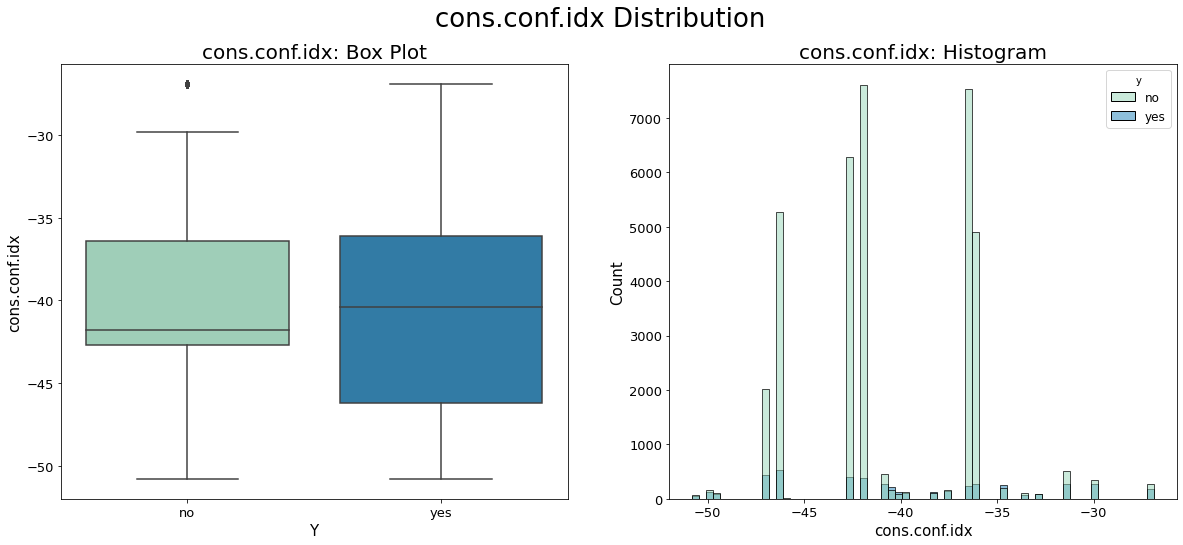

In [57]:
box_hist_plot(df,'cons.conf.idx',"YlGnBu")

<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    19 - euribor 3 month rate <p/>
<p style="font-family: times;line-height: 1.4em; font-size:12pt">
    euribor3m: euribor 3 month rate - daily indicator (numeric)

</p>

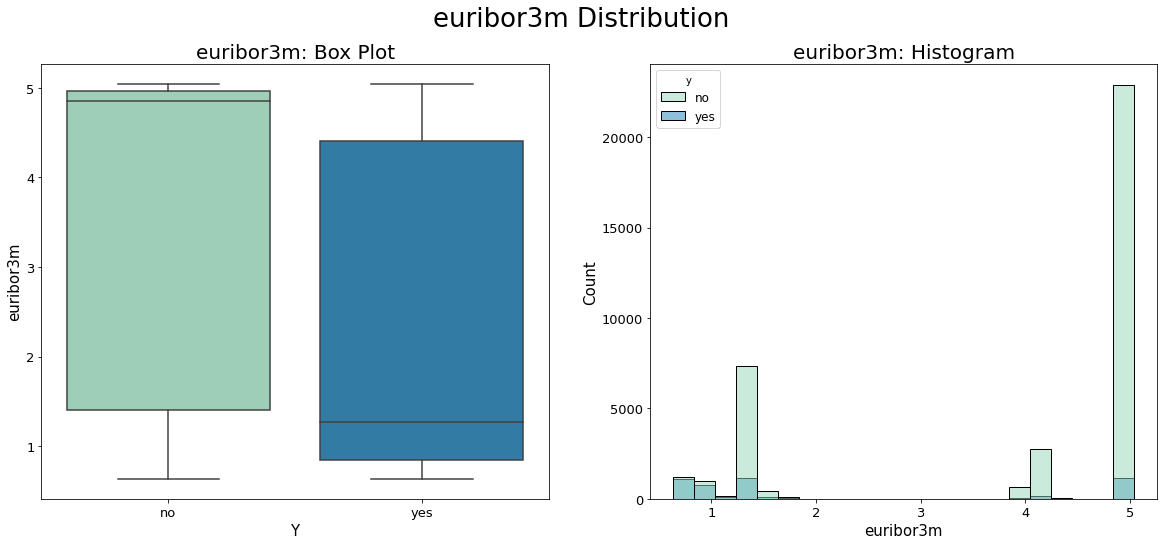

In [58]:
box_hist_plot(df,'euribor3m',"YlGnBu")

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> Euribor is short for Euro Interbank Offered Rate. The Euribor rates are based on the average interest rates at which a large panel of European banks borrow funds from one another. There are different maturities, ranging from one week to one year.
<p style="font-family: times;line-height: 1.4em; font-size:14pt">
The Euribor rates are considered to be the most important reference rates in the European money market. The interest rates do provide the basis for the price and interest rates of all kinds of financial products like interest rate swaps, interest rate futures, saving accounts and mortgages. That’s the exact reason why many professionals as well as individuals do monitor the development of the Euribor rates intensively.

<p style="font-family: times;line-height: 1.4em; font-size:16pt">
    20 - number of employees <p/>
<p style="font-family: times;line-height: 1.4em; font-size:12pt">
    nr.employed: number of employees - quarterly indicator (numeric)

</p>

<p style="font-family: times;line-height: 1.4em; font-size:164ference rates in the European money market. The interest rates do provide the basis for the price and interest rates of all kinds of financial products like interest rate swaps, interest rate futures, saving accounts and mortgages. That’s the exact reason why many professionals as well as individuals do monitor the development of the Euribor rates intensively.

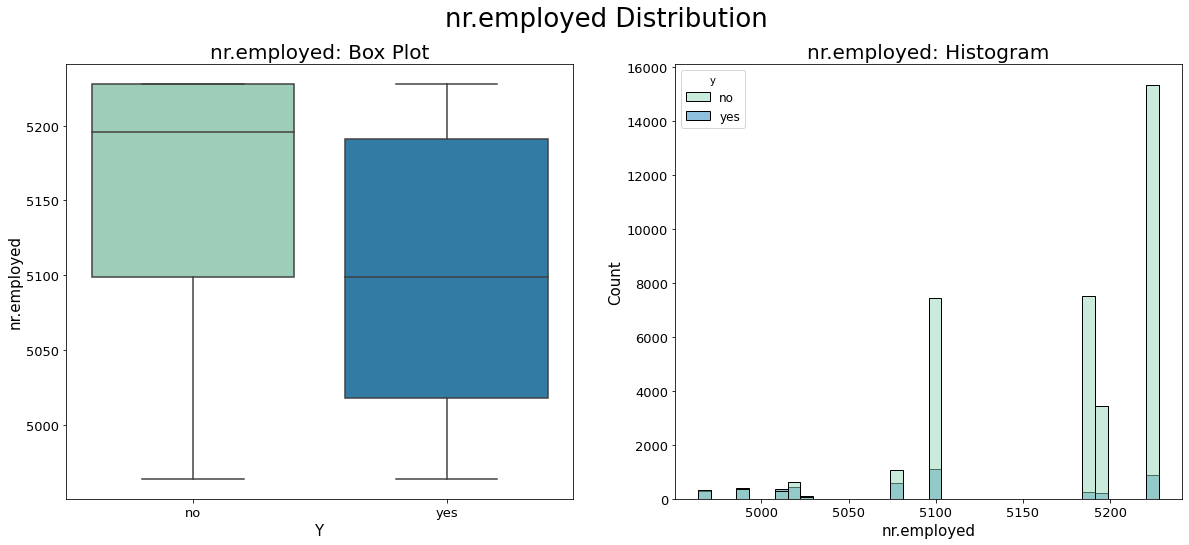

In [59]:
box_hist_plot(df,'nr.employed',"YlGnBu")

<p style="font-family: times;line-height: 1.4em; font-size:16pt">Chi-Square Test of Independence - Categorical FeaturesChi-Square Test of Independence - (Month, Week, Contact)
    


<p style="font-family: times;line-height: 1.4em; font-size:14pt"> The goal of this analysis is to investigate the relationship of the categorical features to the dependent/target variable take deposite rate=y=YES.
The test will determine if there is significant difference in the proportion of those who take deposite rate between the groups in the categorical variable.

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> 
The null hypothesis assumes that theres is no association between the categorical feature and the feature y=YES.
The alternative hypothesis that there is an association between the two variables.

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> 
The alpha statistics is set to 0.05.
If the p-value is lesser than alpha then we will reject the null hypothesis and accept the alternative that the proportions of Churn is dependent with the group in the categorical variable.

[CHI_square test refrence](https://www.kaggle.com/code/grejsegura/telco-data-eda-chi-square-anova-pycaret/notebook)

In [60]:
cat_features = df.select_dtypes(include=['object'])

In [61]:
features = pd.Series(cat_features.drop(['y'], axis=1).columns)

In [62]:
for feature in features:
    chi_square_test(df, feature)

Chi-Square Test for job
degrees of freedom = 11
------------------------------------------------------------
Results:
 
probability = 0.950, critical = 19.675, stat = 961.834
------------------------------------------------------------
Decision based on Chi-Square Statistics:
 
y is dependent on job : (reject H0)
------------------------------------------------------------
Decision based on p-value:
 
alpha = 0.05, p = 0.000
y is dependent on job : (reject H0)
____________________________________________________________
                                                            

                                                            
Chi-Square Test for marital
degrees of freedom = 3
------------------------------------------------------------
Results:
 
probability = 0.950, critical = 7.815, stat = 122.942
------------------------------------------------------------
Decision based on Chi-Square Statistics:
 
y is dependent on marital : (reject H0)
------------------------------

<p style="font-family: times;line-height: 1.4em; font-size:14pt">  From chi square test, we conclude that housing and loan should be discarded as they are not dependant on y (target) variable.

In [63]:
df.drop(['loan','housing'], axis = 1, inplace=True)

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> Let's plot the correlation matrix for only those features with more than 0.7 correlation.

In [64]:
corr = df.corr()
corr_greater_than_75 = corr[corr>=.70]

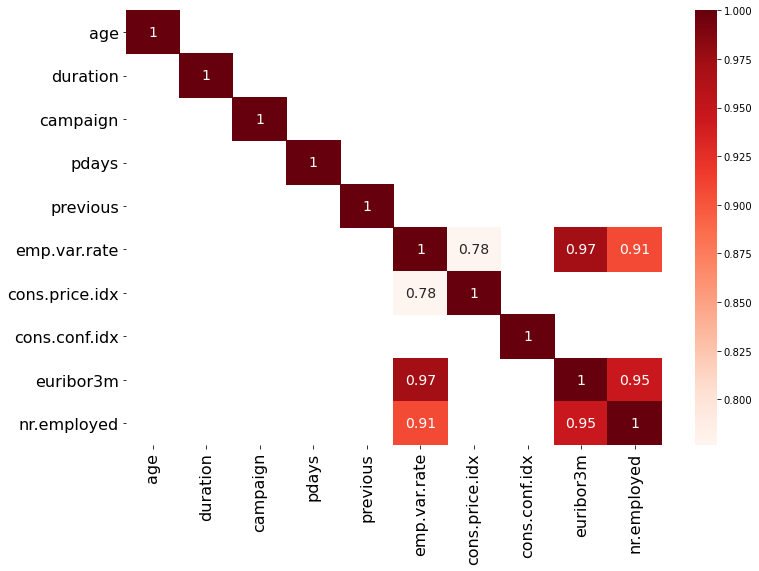

In [65]:
plt.figure(figsize=(12,8))
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
sns.heatmap(corr_greater_than_75, cmap="Reds", annot = True, annot_kws={"fontsize":14});
plt.show()

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> 
    In correlation matrix we are looking to see which variables are fluctuating together. As we see here in heatmap, the emp.var.rate, cons.price.idx, euribor3m and nr.employed features have very high correlation.  So we might need to consider this while selecting our features. Also there is a 078 correlation between emp.var.rate and cons.price.idx.

<p style="font-family: times;line-height: 1.4em; font-size:14pt">  Among these three variables I decided to drop 'emp.var.rate' and 'nr.employed' , as reading about Euribor gave me the idea that this feature is a very important feature in economic decisions in banks.Also by removal of 'emp.var.rate we also would take acoount for correlation between 'emp.var.rate and cons.price.idx.

In [66]:
df.drop(['emp.var.rate', 'nr.employed'], axis = 1, inplace=True)

<p style="font-family: times;line-height: 1.4em; font-weight: bold;font-size:14pt"> 
Do we need to fix the multicollinearity in our regression model? 
    It depends.
<p style="font-family: times;line-height: 1.4em; font-size:14pt"> 
according to reference below (Yufeng):
If the aim of the regressor is purely prediction, the existing multicollinearity in the dataset is not harmful at all. Its prediction power won’t be affected by the correlated variables.
<p style="font-family: times;line-height: 1.4em; font-size:14pt"> 
If the aim of the regressor is to understand the relationship between the independent variables and the dependent variables, the multicollinearity problem needs to be addressed because the correlated variables will compete with each other in explaining the dependent variable.

[Yufeng](https://towardsdatascience.com/consider-multicollinearity-in-my-model-or-not-7aca16e74773)

<p style="font-family: times;line-height: 1.4em; font-size:14pt; color:'blue">  Because of the comment that was given in PdF I will drop 'duration'. Also, we will drop month, day_of_week as disscussed above

In [67]:
df.drop("duration", inplace=True, axis=1)

In [68]:
df.drop(['day_of_week', 'month'], axis=1, inplace = True)

<p style="font-family: times;line-height: 1.4em; font-size:18pt"> 
    Data Pre-Processing:

<p style="font-family: times;line-height: 1.4em; font-size:16pt">  Dealing with Missing Data

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> We have Nan values and also unknown values in our data which we can treat as a category or a missing value. Here we will treat them as another categorical level.

In [69]:
fmissin

Your selected dataframe has 14 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
cons.price.idx,5148,12.5
age,3744,9.1


<p style="font-family: times;line-height: 1.4em; font-size:14pt">  Visualizing missing values in order to have a better undrestanding of the reason this data is missing, does it follows a pattern or not?

<AxesSubplot:>

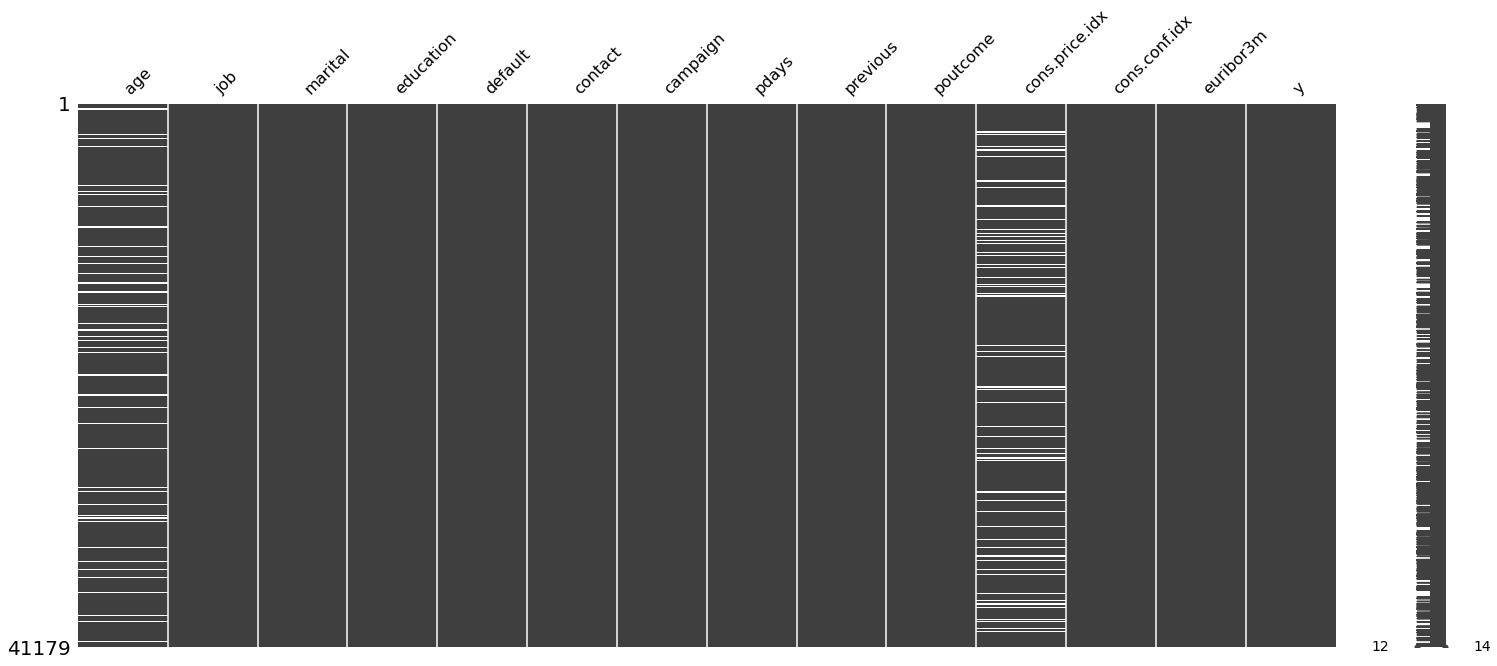

In [70]:
import missingno as msno
msno.matrix(df)

<p style="font-family: times;line-height: 1.4em; font-size:14pt">  As we see, we have a lot of missing values, in columns age and cons.price.idx. We cannot observe why these data re missing and if there is any pattern. Now let's sort the values by age and ons.price.idx columns to see if there is a pattern in the missing values.

<AxesSubplot:>

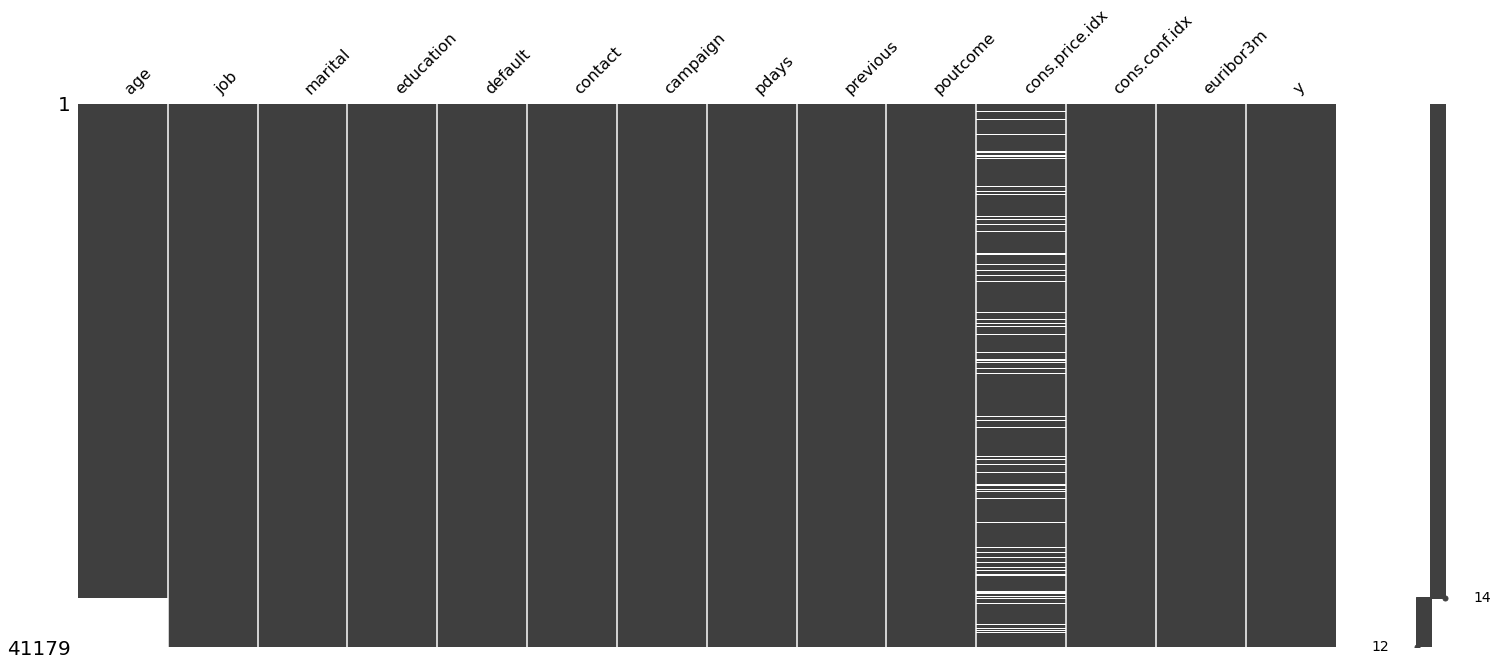

In [71]:
#sorted by Age
sorted = df.sort_values('age')
msno.matrix(sorted)

<p style="font-family: times;line-height: 1.4em; font-size:14pt">  We clearly see there is no pattern between the missingness in age and cons.price.idx column.

<p style="font-family: times;line-height: 1.4em; font-size:16pt">   K-Nearest Neighbor Imputation

In [72]:
from sklearn.impute import KNNImputer
df_knn = df.copy(deep=True)

knn_imputer = KNNImputer(n_neighbors=7, weights="uniform")
df_knn['age'] = knn_imputer.fit_transform(df_knn[['age']])

In [73]:
df_knn['cons.price.idx'] = knn_imputer.fit_transform(df_knn[['cons.price.idx']])

In [74]:
summary(df_knn,'age')

Min age:  17.0
Max age:  98.0
Median age:  40.0
Mode of age is:  39.999278749833046
Standard diveation of age is:  9.93
  
1st Quartile:  33.0
2nd Quartile:  39.0
3rd Quartile:  46.0
4th Quartile:  98.0
age above:  65.5 are outliers
  
Numerber of outliers:  557
Number of clients:  41179
Outliers are: 1.35 %


In [75]:
summary(df,'age')

Min age:  17.0
Max age:  98.0
Median age:  40.0
Mode of age is:  31.0
Standard diveation of age is:  10.41
  
1st Quartile:  32.0
2nd Quartile:  38.0
3rd Quartile:  47.0
4th Quartile:  98.0
age above:  69.5 are outliers
  
Numerber of outliers:  423
Number of clients:  41179
Outliers are: 1.03 %


In [76]:
missing_data= missing_values_table(df_knn)
missing_data

Your selected dataframe has 14 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


<p style="font-family: times;line-height: 1.4em; font-size:16pt">  Multivariate feature imputation - Multivariate imputation by chained equations (MICE)

In [77]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# df_mice = df.copy(deep=True)

# mice_imputer = IterativeImputer()
# df_mice['age'] = mice_imputer.fit_transform(df_mice[['age']])
# df_mice['cons.price.idx'] = mice_imputer.fit_transform(df_mice[['cons.price.idx']])

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> Results from Multivariate feature imputation and KNN where same, comparing the summary of data, so I commented out this methode and continued with KNN imputation.

<p style="font-family: times;line-height: 1.4em; font-size:16pt"> Dealing with duplicate Values

In [78]:
df_final= df_knn.copy()

In [79]:
df_final.shape

(41179, 14)

<p style="font-family: times;line-height: 1.4em; font-size:16pt"> Last Prepration for Modling

In [80]:
num_cols = list(df_final.select_dtypes(exclude=['object']))

cat_cols = list(df_final.select_dtypes(include=['object']))[:-1]

print(f'we have {len(num_cols)} numerical columns:{num_cols}')
print('---'*35)
print(f'we have {len(cat_cols)} categorical columns:  {cat_cols}')

we have 7 numerical columns:['age', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
---------------------------------------------------------------------------------------------------------
we have 6 categorical columns:  ['job', 'marital', 'education', 'default', 'contact', 'poutcome']


In [81]:
cat_cols=['job', 'marital', 'education', 'default', 'poutcome']

In [82]:
num_cols = ['age', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']

<p style="font-family: times;line-height: 1.4em; font-size:16pt"> Converting Categorical Variables

In [83]:
# Get the dummy variables for contact, poutcome , job, month, marital, day_of_week, education
# Let's drop the first column from  using 'drop_first = True' as first column can be derived using other columns 
# (dropping redundant column)

job = pd.get_dummies(df_final.job, drop_first=True)
marital = pd.get_dummies(df_final.marital, drop_first=True)
education = pd.get_dummies(df.education, drop_first=True)
default = pd.get_dummies(df.default, drop_first=True)
poutcome = pd.get_dummies(df.poutcome, drop_first=True)
contact = pd.get_dummies(df.contact, drop_first=True)

In [84]:
df = pd.concat([df_final, job, marital, education, default, poutcome , contact], axis=1)
df.drop(['job', 'marital', 'education','default', 'poutcome' , 'contact'], axis = 1, inplace = True)
df.head()

,age,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,y,blue-collar,entrepreneur,...,high.school,illiterate,professional.course,university.degree,unknown,unknown,yes,nonexistent,success,telephone
0,56.0,1,999,0,93.994000,-36.4,4.857,no,0,0,...,0,0,0,0,0,0,0,1,0,1
1,57.0,1,999,0,93.994000,-36.4,4.857,no,0,0,...,1,0,0,0,0,1,0,1,0,1
2,37.0,1,999,0,93.575615,-36.4,4.857,no,0,0,...,1,0,0,0,0,0,0,1,0,1
3,40.0,1,999,0,93.994000,-36.4,4.857,no,0,0,...,0,0,0,0,0,0,0,1,0,1
4,56.0,1,999,0,93.575615,-36.4,4.857,no,0,0,...,1,0,0,0,0,0,0,1,0,1


<p style="font-family: times;line-height: 1.4em; font-size:16pt"> Target Variable

In [85]:
# Converting target variable y from categorical 'yes' and 'no' in terms of 0 and 1and read Y seperately
y = Y.map({'yes': 1, 'no': 0})

# Define X
X = df.drop('y', axis=1)

In [86]:
X.head()

,age,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,blue-collar,entrepreneur,housemaid,...,high.school,illiterate,professional.course,university.degree,unknown,unknown,yes,nonexistent,success,telephone
0,56.0,1,999,0,93.994000,-36.4,4.857,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,57.0,1,999,0,93.994000,-36.4,4.857,0,0,0,...,1,0,0,0,0,1,0,1,0,1
2,37.0,1,999,0,93.575615,-36.4,4.857,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,40.0,1,999,0,93.994000,-36.4,4.857,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,56.0,1,999,0,93.575615,-36.4,4.857,0,0,0,...,1,0,0,0,0,0,0,1,0,1


<p style="font-family: times;line-height: 1.4em; font-size:16pt"> Splitting The Data

In [87]:
# We will divide the training and testing set in 70% and 30% respectively
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.3, random_state=42)

In [88]:
print("Train Dataset: "+ str(len(X_train)) + " Test Dataset: " + str(len(X_test)))
print('='*50)
print("Train Target Label counts: ")
print(y_train.value_counts())
print('-'*50)
print("Test Target Label counts: ")
print(y_test.value_counts())

Train Dataset: 28825 Test Dataset: 12354
Train Target Label counts: 
0    25578
1     3247
Name: y, dtype: int64
--------------------------------------------------
Test Target Label counts: 
0    10962
1     1392
Name: y, dtype: int64


In [89]:
X_train.head()

,age,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,blue-collar,entrepreneur,housemaid,...,high.school,illiterate,professional.course,university.degree,unknown,unknown,yes,nonexistent,success,telephone
21520,36.000000,2,999,0,93.444,-36.1,4.963,0,0,0,...,0,0,0,1,0,0,0,1,0,0
17023,39.999279,7,999,0,93.918,-42.7,4.962,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24563,42.000000,2,999,1,93.200,-42.0,4.191,0,0,0,...,0,0,0,1,0,0,0,0,0,0
20192,36.000000,9,999,0,93.444,-36.1,4.965,0,0,1,...,0,0,0,0,0,0,0,1,0,0
38457,22.000000,2,6,1,92.431,-26.9,0.730,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [90]:
df.isnull().sum()

age                    0
campaign               0
pdays                  0
previous               0
cons.price.idx         0
cons.conf.idx          0
euribor3m              0
y                      0
blue-collar            0
entrepreneur           0
housemaid              0
management             0
retired                0
self-employed          0
services               0
student                0
technician             0
unemployed             0
unknown                0
married                0
single                 0
unknown                0
basic.6y               0
basic.9y               0
high.school            0
illiterate             0
professional.course    0
university.degree      0
unknown                0
unknown                0
yes                    0
nonexistent            0
success                0
telephone              0
dtype: int64

<p style="font-family: times;line-height: 1.4em; font-size:16pt"> Rescaling Continuous Variables

In [91]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler Object
scaler = MinMaxScaler()

In [92]:
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform (X_test[num_cols])

In [93]:
X_train.head(3)

,age,campaign,pdays,previous,cons.price.idx,cons.conf.idx,euribor3m,blue-collar,entrepreneur,housemaid,...,high.school,illiterate,professional.course,university.degree,unknown,unknown,yes,nonexistent,success,telephone
21520,0.234568,0.018182,1.0,0.000000,0.484412,0.615063,0.981410,0,0,0,...,0,0,0,1,0,0,0,1,0,0
17023,0.283942,0.109091,1.0,0.000000,0.669135,0.338912,0.981183,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24563,0.308642,0.018182,1.0,0.142857,0.389322,0.368201,0.806393,0,0,0,...,0,0,0,1,0,0,0,0,0,0


<p style="font-family: times;line-height: 1.4em; font-size:20pt ; font-weight: bold">   Performance Metrics

<p style="font-family: times;line-height: 1.4em; font-size:14pt">  Here, I believe False Positive is more important, as it means we falsly predicted the client will take the deposite rate but they won't, so we won't invest on them and we will loose them. One the other hand, false negative means, the client has subscribed but the model predicted they won't, which can be bad if we invested on them, but either way they would have subcribed. So it really depends on the business plan we have, we should see what is our goal, to keep our customers ( which economic wise is cheaper, since you don't need investment for absorbing them), or we want to acquire new customers. 
AUC-ROC curve plots the TPR against FPR at various threshold values . The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. SO AUC can be also a metric to compare.
Here I showed all metrics, but tried to optimize models for roc_auc. 

<p style="font-family: times;line-height: 1.4em; font-size:20pt ; font-weight: bold">   Model Selection

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> I choose Logistic Regression , Random Forest and Decision Trees as three models to achieve our goal which is to predict if the client will subscribe to a term product (variable Y).

> <p style="font-family: times;line-height: 1.4em; font-size:14pt"> Logistic regression is chosen because it is mainly used when the dependent variable is binary in nature, it is easy to implement,interpret, and very efficient to train.We can interpret model coefficients as indicators of feature importance.

> <p style="font-family: times;line-height: 1.4em; font-size:14pt"> Decision Tree is very robust to outliers, and very easy to train. It is very interpretable, and very intuitive and easy to explain to technical teams as well as stakeholders. and highly usefull for classification tasks as well as regressions. specially in cases like ours where data size is not that large and is not high dimensional.

> <p style="font-family: times;line-height: 1.4em; font-size:14pt"> Random Forest has all advantages of decision tree and also it avoids and prevents overfitting by using multiple trees.However, Decision trees are much easier to interpret and understand. Since a random forest combines multiple decision trees, it becomes more difficult to interpret.

<p style="font-family: times;line-height: 1.4em; font-size:20pt ; font-weight: bold">  Logistic Regression

<p style="font-family: times;line-height: 1.4em; font-size:14pt">  We have imbalanced data set one way to deal with that is to do upscaling or downscaling however here in logistic regression we can use class-weight to deal with this as well, which in a way the algorithm is punished for any wrong prediction of that class

<p style="font-family: times;line-height: 1.4em; font-size:14pt">  1) First building a logistic regression with default weights

In [94]:
# define model
lgR = LogisticRegression(random_state=42, class_weight=None)
# fit it
lgR.fit(X_train,y_train)

LogisticRegression(random_state=42)

In [95]:
# test
y_pred_lgR = lgR.predict(X_test)
y_pred_lgR_train = lgR.predict(X_train)


auc=roc_auc_score(y_test, y_pred_lgR)
acc = accuracy_score(y_test, y_pred_lgR )
prec = precision_score(y_test, y_pred_lgR )
rec = recall_score(y_test, y_pred_lgR )
f1 = f1_score(y_test, y_pred_lgR )

results= pd.DataFrame([['Logit-Unweighted', acc,auc, prec, rec, f1]],
                      columns = ['Model', 'Accuracy','AUC', 'Precision', 
                                 'Recall', 'F1 Score', ])


results = results.sort_values(["AUC","Accuracy", "Recall"], ascending = False)
print (results)

              Model  Accuracy       AUC  Precision    Recall  F1 Score
0  Logit-Unweighted  0.897604  0.583875   0.671159  0.178879  0.282473


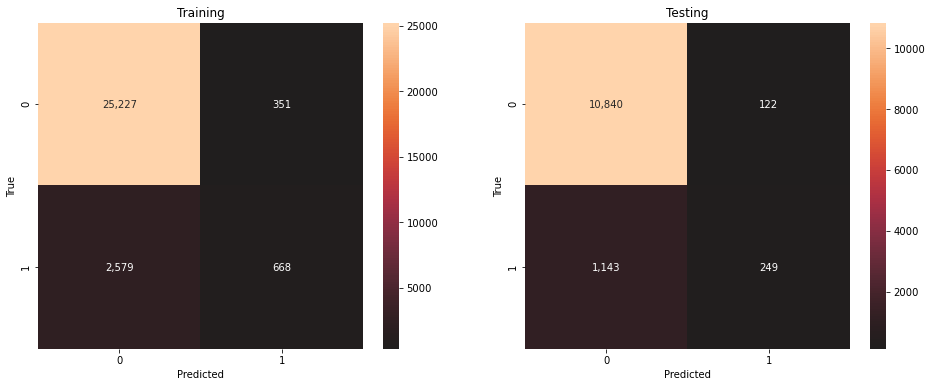

In [96]:
# output confusion matrix of_ros training and test results
confmat([y_train, y_test], [y_pred_lgR_train, y_pred_lgR], ["Training", "Testing"])
plt.show()

<p style="font-family: times;line-height: 1.4em; font-size:14pt">  For minority class, above model is able to predict 351 correct out of 1392 samples. For majority class, model got 122 prediction wrong out of 10962 observations. Model is not doing a good job in predicting minority class. Nonetheless, with these default weights performance values, we got benchmark to measure subsequent model modifications.

<p style="font-family: times;line-height: 1.4em; font-size:20pt ; font-weight: bold">  Weighted Logistic Regression

<p style="font-family: times;line-height: 1.4em; font-size:14pt">  In case be unbalanced label distribution, the best practice for weights is to use the inverse of the label distribution. In our set, label distribution is 4639:36540 = 126:1000 so we can specify weights as inverse of label distribution. For majority class, will use weight of 1 and for minority class, will use weight of 7.93. So the penalty of wrong prediction of minority class would be 2.26 times more severe than wrong prediction of majority class.

In [97]:
# define class weights
w = {0:1, 1:7.93}
# define model
lg2 = LogisticRegression(random_state=42, class_weight=w)
# fit it
lg2.fit(X_train,y_train)

LogisticRegression(class_weight={0: 1, 1: 7.93}, random_state=42)

In [98]:
# test
y_pred_lg2_test = lg2.predict(X_test)
# train
y_pred_lg2_train = lg2.predict(X_test)

In [99]:
results=results_table(lg2,'Weighted Logit',results)
results

,Model,Accuracy,AUC,Precision,Recall,F1 Score
1,Weighted Logit,0.778776,0.737052,0.293247,0.683190,0.410356
0,Logit-Unweighted,0.897604,0.583875,0.671159,0.178879,0.282473


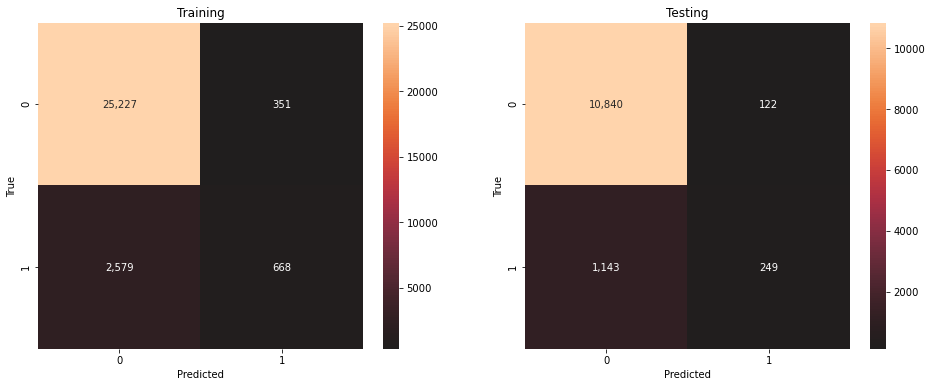

In [100]:
# output confusion matrix of_ros training and test results
confmat([y_train, y_test], [y_pred_lgR_train, y_pred_lgR], ["Training", "Testing"])
plt.show()

<p style="font-family: times;line-height: 1.4em; font-size:16pt">  Weights GridSearch

In [101]:
# define weight hyperparameter
w = [{0:1,1:5},{0:1,1:3}, {0:1,1:2}, 
     {0:1,1:1.5}, {0:1,1:4},  
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
hyperparam_grid = {"class_weight": w }

In [102]:
# define model
lg3 = LogisticRegression(random_state=42)
# define evaluation procedure
grid = GridSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True,verbose=2)
# grid.fit(X_train,y_train)
# print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> Using above weight values, lets build logistic regression

In [103]:
# define model
lg4 = LogisticRegression(random_state=42, class_weight= {0: 1.0, 1: 10})
# fit it
lg4.fit(X_train,y_train)
# test
y_pred_lg4 = lg4.predict(X_test)

In [104]:
results=results_table(lg4,'Tuned-Weighted Logit ',results)
results

,Model,Accuracy,AUC,Precision,Recall,F1 Score
0,Weighted Logit,0.778776,0.737052,0.293247,0.683190,0.410356
2,Tuned-Weighted Logit,0.748988,0.733751,0.268867,0.714080,0.390646
1,Logit-Unweighted,0.897604,0.583875,0.671159,0.178879,0.282473


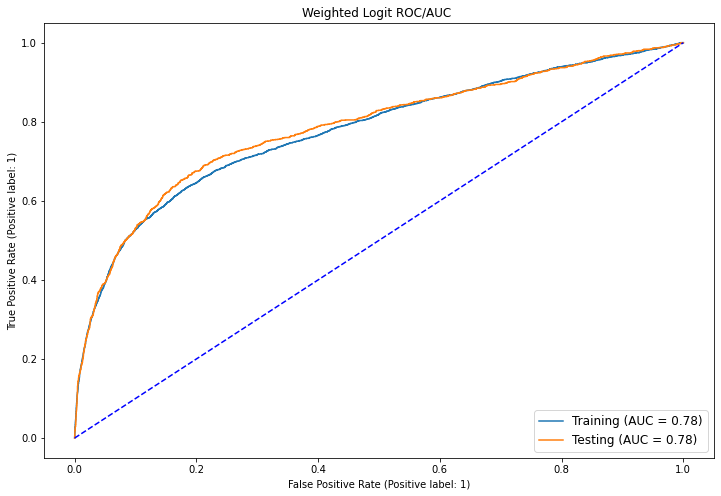

In [105]:
ROC_curve(lg2,'Weighted Logit')

In [106]:
#confmat(y_true, y_pred, title)
#results_table(model,model_name,results)

<p style="font-family: times;line-height: 1.4em; font-size:16pt"> Tuned Weighted Logistic Regression

In [107]:
lr_tuned = LogisticRegression()

In [108]:
# Create the param grid for logistic regression
lr_param_grid = {
    "class_weight": [{0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}],
    'max_iter': [75, 100, 125],
    'penalty': ['l1', 'l2'],
    'C': [0.5 , 1],
    'solver': ['liblinear', 'lbfgs']
}

In [109]:
grid_search = GridSearchCV(lr_tuned,lr_param_grid,scoring="roc_auc",
                                cv = 5, verbose=2, n_jobs = -1)

In [110]:
# lr_tuned_grid_search = grid_search.fit(X_train, y_train)

In [111]:
# print(grid_search.best_estimator_)

In [112]:
lr_tuned_best=LogisticRegression(C=1.5, class_weight={0: 0.01, 1: 1.0},
                                 penalty='l1',solver='liblinear')


In [113]:
lr_tuned_best.fit(X_train,y_train)

LogisticRegression(C=1.5, class_weight={0: 0.01, 1: 1.0}, penalty='l1',
                   solver='liblinear')

In [114]:
tuned_lr_pred_test = lr_tuned_best.predict(X_test)
tuned_lr_pred_train = lr_tuned_best.predict(X_train)

In [115]:
results=results_table(lr_tuned_best,'Tuned Logit (weighted)',results)
results

,Model,Accuracy,AUC,Precision,Recall,F1 Score
0,Weighted Logit,0.778776,0.737052,0.293247,0.683190,0.410356
1,Tuned-Weighted Logit,0.748988,0.733751,0.268867,0.714080,0.390646
2,Logit-Unweighted,0.897604,0.583875,0.671159,0.178879,0.282473
3,Tuned Logit (weighted),0.112676,0.500000,0.112676,1.000000,0.202532


<p style="font-family: times;line-height: 1.4em; font-size:16pt"> Feature Importance for Logistic Regression (Best Model)

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> As we see from results, the best model amongs tuned logistic regression models is Weight Logit, so we will do feature importance for that.

In [116]:
coefficients = lg2.coef_[0]

                    coef
cons.price.idx  1.442603
cons.conf.idx   1.195341
illiterate      0.731424
success         0.727741
unknown         0.561075
nonexistent     0.526710
retired         0.522842
student         0.278066
basic.6y        0.238736
unknown         0.230711


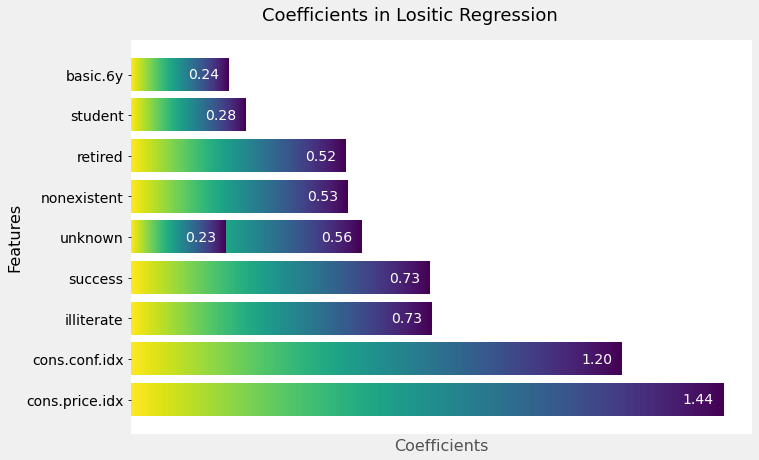

In [117]:
coeff_barplot(coefficients,'Lositic Regression')

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> For Logistic Regression model the most important feature seems to be cons.price.idx , and then cons.conf.idx, and after that ilitrate.

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> As we see here we have "unknown" which we don't knoe it belongs to which feature, so going back I would change the unknown label and specify the featyre it belongs to. 

<p style="font-family: times;line-height: 1.4em; font-size:20pt ; font-weight: bold">  Random Forest

In [118]:
rfc = RandomForestClassifier(n_estimators = 200)#criterion = entopy,gini
rfc.fit(X_train, y_train)
rfc_pred_test = rfc.predict(X_test)

In [119]:
results=results_table(rfc,'Random Forest',results)
results

,Model,Accuracy,AUC,Precision,Recall,F1 Score
0,Weighted Logit,0.778776,0.737052,0.293247,0.683190,0.410356
1,Tuned-Weighted Logit,0.748988,0.733751,0.268867,0.714080,0.390646
4,Random Forest,0.892343,0.622617,0.544160,0.274425,0.364852
2,Logit-Unweighted,0.897604,0.583875,0.671159,0.178879,0.282473
3,Tuned Logit (weighted),0.112676,0.500000,0.112676,1.000000,0.202532


In [120]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

In [121]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [122]:
rf = RandomForestClassifier()

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> Use the random grid to search for best hyperparameters . Random search of parameters, using 3 fold cross validation,search across 100 different combinations, and use all available cores

In [123]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid,scoring="roc_auc",
                               n_iter = 100, cv = 4, verbose=2, random_state=42, 
                               n_jobs = -1)

In [124]:
#the best parameters from fitting the random search
# random_search.fit(X_train, y_train)
# print(random_search.best_estimator_)

<p style="font-family: times;line-height: 1.4em; font-size:16pt"> Grid Search with Cross Validation

In [125]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid_mod = {
    'max_depth': [85, 90, 95],
    'min_samples_leaf': [6, 8 ,10],
    'min_samples_split': [10,15,20],
    'n_estimators': [200,250,300]
}

In [126]:
grid_search = GridSearchCV(rf,param_grid_mod,scoring="roc_auc",
                                cv = 5, verbose=2, n_jobs = -1)

In [127]:
# best_grid_search = grid_search.fit(X_train, y_train)

In [128]:
# print(grid_search.best_estimator_)

<p style="font-family: times;line-height: 1.4em; font-size:16pt">  Evaluating our classifier parameters with new optimized parameters

In [129]:
rfc_tuned=RandomForestClassifier(max_depth=85, min_samples_leaf=8, min_samples_split=10,
                       n_estimators=250)

In [130]:
rfc_tuned.fit(X_train,y_train)

RandomForestClassifier(max_depth=85, min_samples_leaf=8, min_samples_split=10,
                       n_estimators=250)

In [131]:
tuned_rfc_pred_test = rfc_tuned.predict(X_test)
tuned_rfc_pred_train = rfc_tuned.predict(X_train)

In [132]:
results=results_table(rfc_tuned,'Tuned Random Forest',results)
results

,Model,Accuracy,AUC,Precision,Recall,F1 Score
0,Weighted Logit,0.778776,0.737052,0.293247,0.683190,0.410356
1,Tuned-Weighted Logit,0.748988,0.733751,0.268867,0.714080,0.390646
2,Random Forest,0.892343,0.622617,0.544160,0.274425,0.364852
5,Tuned Random Forest,0.901085,0.596812,0.713568,0.204023,0.317318
3,Logit-Unweighted,0.897604,0.583875,0.671159,0.178879,0.282473
4,Tuned Logit (weighted),0.112676,0.500000,0.112676,1.000000,0.202532


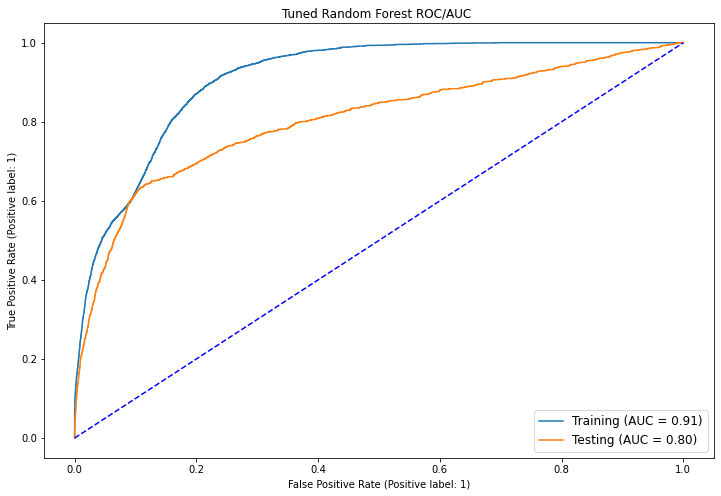

In [133]:
ROC_curve(rfc_tuned,'Tuned Random Forest')

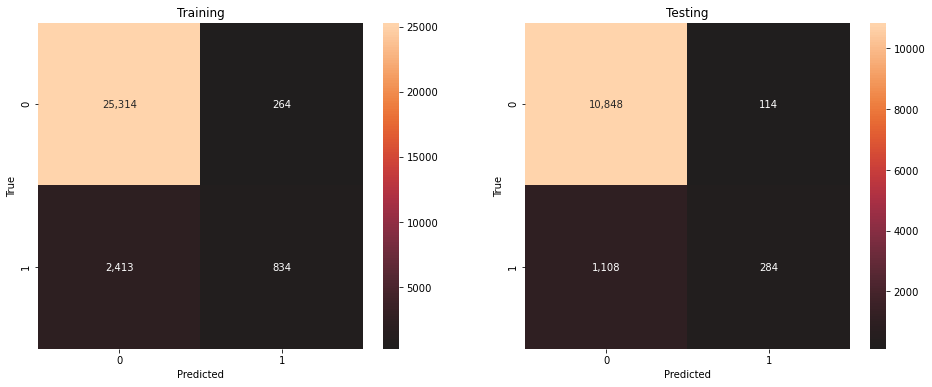

In [134]:
# output confusion matrix of_ros training and test results
confmat([y_train, y_test], [tuned_rfc_pred_train, tuned_rfc_pred_test], ["Training", "Testing"])
plt.show()

<p style="font-family: times;line-height: 1.4em; font-size:16pt"> Feature Importance for Random Forest

In [135]:
coefficients = rfc.feature_importances_

                    coef
euribor3m       0.228569
age             0.214250
campaign        0.096504
cons.conf.idx   0.066667
cons.price.idx  0.064194
pdays           0.050828
success         0.024907
previous        0.020419
married         0.018329
technician      0.016708


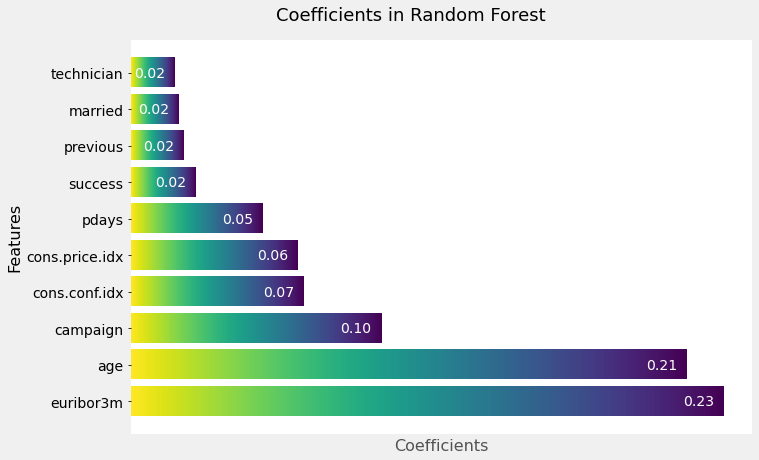

In [136]:
coeff_barplot(coefficients,'Random Forest')

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> For Random Forest model the most important feature seems to be eurobor-3month, and then age, and after that campaign.

<p style="font-family: times;line-height: 1.4em; font-size:20pt ; font-weight: bold">  Decision Tree

<p style="font-family: times;line-height: 1.4em; font-size:16pt"> Tuned Decision Tree

In [137]:
dt = DecisionTreeClassifier(random_state=42)

In [138]:
# Create the param grid for Decision Tree
dt_param_grid = {
            'max_depth':np.arange(3,20),
            'min_samples_split': np.arange(3,20,1),
            'min_samples_leaf':np.arange(3,30),
            'min_samples_split' : np.arange(3,30),
            'criterion': ('gini', 'entropy')
                }

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> Use the random grid to search for best hyperparameters . Random search of parameters, using 3 fold cross validation,search across 100 different combinations, and use all available cores

In [139]:
random_search = RandomizedSearchCV(estimator = dt, param_distributions = dt_param_grid,scoring="roc_auc",
                               n_iter = 100, cv = 3, verbose=2, random_state=42, 
                               n_jobs = -1)

In [140]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ('gini', 'entropy'),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'min_samples_leaf': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'min_samples_split': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
                   random_state=42, scoring='roc_auc', verbose=2)

<p style="font-family: times;line-height: 1.4em; font-size:14pt">  the best parameters from fitting the random search

In [141]:
print(random_search.best_estimator_)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=21,
                       min_samples_split=3, random_state=42)


<p style="font-family: times;line-height: 1.4em; font-size:16pt"> Grid Search with Cross Validation

In [142]:
dt_rand_tuned=DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=21,
                       min_samples_split=3, random_state=42)

In [143]:
# Create the parameter grid based on the results of random search 
param_grid_mod = {
            'max_depth':[6,  7,  8],
            'min_samples_split': [2,3],
            'min_samples_leaf':[20, 21, 22],
            'min_samples_split' : [2,3],
            'criterion': ['entropy']
}

In [144]:
grid_search = GridSearchCV(dt_rand_tuned,param_grid_mod,scoring="roc_auc",
                                cv = 5, verbose=2, n_jobs = -1)

best_grid_search = grid_search.fit(X_train, y_train)

print(grid_search.best_estimator_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=22,
                       random_state=42)


<p style="font-family: times;line-height: 1.4em; font-size:16pt">  Evaluating our classifier parameters with new optimized parameters

In [145]:
dt_tuned=DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=22,
                       random_state=42)

dt_tuned.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=22,
                       random_state=42)

In [146]:
tuned_dt_pred_test = dt_tuned.predict(X_test)
tuned_dt_pred_train = dt_tuned.predict(X_train)

In [147]:
results=results_table(dt_tuned,'Tuned Decision Tree',results)
results

,Model,Accuracy,AUC,Precision,Recall,F1 Score
0,Weighted Logit,0.778776,0.737052,0.293247,0.683190,0.410356
1,Tuned-Weighted Logit,0.748988,0.733751,0.268867,0.714080,0.390646
2,Random Forest,0.892343,0.622617,0.544160,0.274425,0.364852
6,Tuned Decision Tree,0.901408,0.616436,0.667954,0.248563,0.362304
3,Tuned Random Forest,0.901085,0.596812,0.713568,0.204023,0.317318
4,Logit-Unweighted,0.897604,0.583875,0.671159,0.178879,0.282473
5,Tuned Logit (weighted),0.112676,0.500000,0.112676,1.000000,0.202532


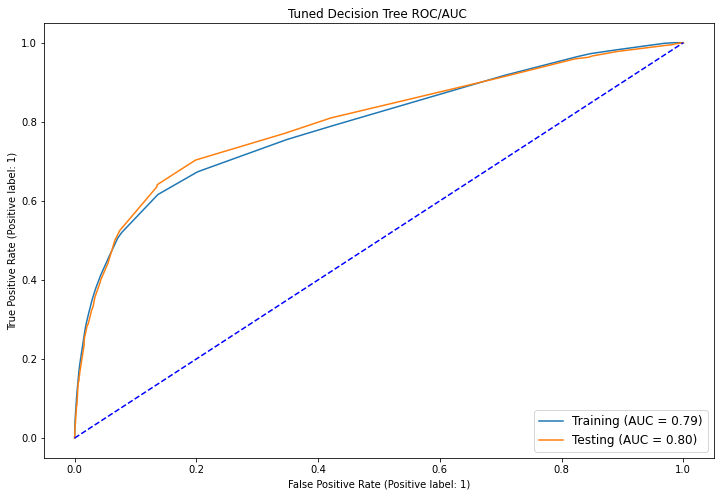

In [148]:
ROC_curve(dt_tuned,'Tuned Decision Tree')

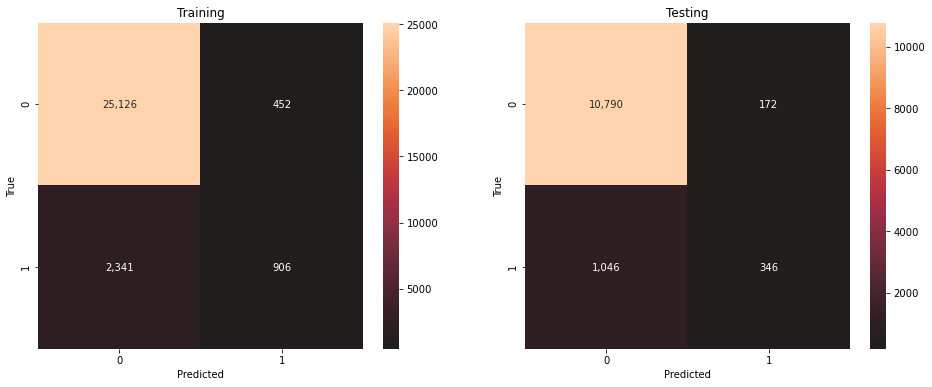

In [149]:
# output confusion matrix of_ros training and test results
confmat([y_train, y_test], [tuned_dt_pred_train, tuned_dt_pred_test], ["Training", "Testing"])
plt.show()

In [150]:
coefficients= dt_tuned.feature_importances_

                    coef
euribor3m       0.786222
pdays           0.089488
cons.conf.idx   0.048114
cons.price.idx  0.036121
telephone       0.009031
campaign        0.008127
nonexistent     0.005546
age             0.004198
technician      0.003440
success         0.002881


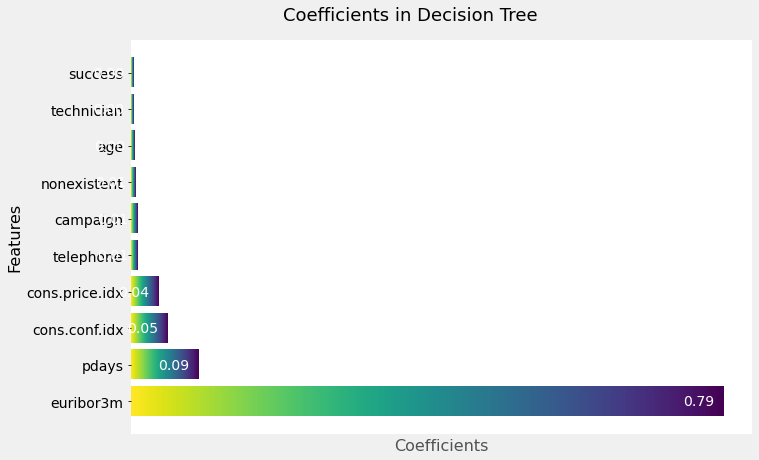

In [151]:
coeff_barplot(coefficients,'Decision Tree')

<p style="font-family: times;line-height: 1.4em; font-size:14pt"> Here the most important feature seems to be eurobor-3month, and then pdays.

<p style="font-family: times;line-height: 1.4em; font-size:20pt ; font-weight: bold">  What Extra Data?

<p style="font-family: times;line-height: 1.4em; font-size:14pt">If you could ask the bank for any additional data to solve the problem, what data would you ask and why? 

data that is specific to each client:

### Data that is specific to each client:

- Client Income : gives information financial state of the client
- number of children : gives information financial state of the client
- owner of house or rented: gives information financial state of the client
- Assets: gives information financial state of the client
- neighbourhood they live: gives information financial state of the client
- how long they have been with bank: Loyalty
- credit score: Credibility

### Data that is not client specific:
    
- Interest rates offered in campaign:(run an A/B test, to see the effec of changing parameters in this offered products)
- duration of subscription and deposite rate (run A/B test)
- information on if there is any offers and what offers , during or after subscribtion (for only those who subscribe to deposite rate):
- This offers be beneficial to his/her needs so it be more motivational for that person


<p style="font-family: times;line-height: 1.4em; font-size:20pt ; font-weight: bold">   Thanks